Possible improvements:

- Use the crosscheck table to merge DR2 and DR3

- Check the mass: some stars do not have mass information? 


note: adding the last constrint "ap.mass_flame IS NOT NULL" decreases the number of results from 408 to 218



In [1]:
from astroquery.gaia import Gaia
# Gaia.MAIN_GAIA_TABLE = "gaiadr2.gaia_source"  # Select Data Release 2
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"  # Reselect Data Release 3, default

import numpy as np
import matplotlib.pyplot as plt
from astroquery.simbad import Simbad



In [2]:
from openpyxl import load_workbook

def adjust_column_widths(excel_file):
    """
    Load an Excel workbook, adjust the column widths based on the maximum length of data in each column,
    and save the workbook.

    Parameters:
    - directory: str, the path to the directory containing the Excel file.
    - excel_file: str, the name of the Excel file to be processed.
    """
    # Load the workbook and select the active worksheet
    workbook = load_workbook(excel_file)
    worksheet = workbook.active

    # Adjust the column widths
    for column in worksheet.columns:
        max_length = 0
        column_letter = column[0].column_letter  # Get the column letter
        for cell in column:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
            except:
                pass
        adjusted_width = (max_length + 2)
        worksheet.column_dimensions[column_letter].width = adjusted_width

    # Save the workbook
    workbook.save(excel_file)




In [3]:
def calculate_habitable_zone(T_eff, L_ratio):
    """
    Calculate the habitable zone boundary based on Kopparapu et al. (2013) Equations 2 & 3,
    using only the "Runaway Greenhouse" limit (Conservative inner boundary).
    
    Parameters:
    T_eff (float): Effective temperature of the star in Kelvin
    
    Returns:
    float: Distance of the habitable zone boundary in AU
    """

    T_sun = 5780  # Effective temperature of the Sun in Kelvin

    # Coefficients for "Runaway Greenhouse" from Table 3 in the paper
    S_eff_sun, a, b, c, d = [1.0512, 1.3242E-4, 1.5418E-8, -7.9895E-12, -1.8328E-15]

    '''
    "Recent Venus": 
    S_eff_sun, a, b, c, d = [1.7753, 1.4316E-4, 2.9875E-9, -7.5702E-12, -1.1635E-15]
    "Runaway Greenhouse": 
    S_eff_sun, a, b, c, d = [1.0512, 1.3242E-4, 1.5418E-8, -7.9895E-12, -1.8328E-15]
    "Moist Greenhouse":
    S_eff_sun, a, b, c, d = [1.0140, 8.1774E-5, 1.7063E-9, -4.3241E-12, -6.6462E-16]
    "Maximum Greenhouse":
    S_eff_sun, a, b, c, d = [0.3438, 5.8942E-5, 1.6558E-9, -3.0045E-12, -5.2983E-16]
    "Early Mars":
    S_eff_sun, a, b, c, d = [0.3179, 5.4513E-5, 1.5313E-9, -2.7786E-12, -4.8997E-16]
    '''

    T_star = T_eff - 5780
    S_eff = S_eff_sun + a*T_star + b*T_star**2 + c*T_star**3 + d*T_star**4
    distance = np.sqrt(L_ratio / S_eff)
    
    return distance

### 1. Qeury Gaia DR2/3 data

names: https://gaia.aip.de/metadata/gaiadr3/gaia_source/

In [267]:
import pandas as pd
from astroquery.gaia import Gaia

# Query for the supplementary table
query_supp = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.bp_rp, gs.parallax, ap.teff_gspphot_marcs, ap.mass_flame_spec, ap.lum_flame_spec, ap.radius_flame_spec
FROM gaiadr3.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters_supp AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 12 
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 10
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
"""

# Execute the supplementary table query
job_supp = Gaia.launch_job_async(query_supp)
results_supp = job_supp.get_results().to_pandas()

# Query for the main table
query_main = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.bp_rp, gs.parallax, gs.teff_gspphot, ap.mass_flame, ap.lum_flame, ap.radius_flame, ap.spectraltype_esphs
FROM gaiadr3.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 12 
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 10
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
"""

# Execute the main table query
job_main = Gaia.launch_job_async(query_main)
results_main = job_main.get_results().to_pandas()

# Convert source_id columns to strings
results_main['source_id'] = results_main['source_id'].astype(str)
results_supp['source_id'] = results_supp['source_id'].astype(str)

# Select only unique columns from each dataset
results_supp_unique = results_supp[['source_id', 'teff_gspphot_marcs', 'mass_flame_spec', 'lum_flame_spec', 'radius_flame_spec']]
results_main_unique = results_main[['source_id', 'ra', 'dec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'parallax', 'teff_gspphot', 'mass_flame', 'lum_flame', 'radius_flame', 'spectraltype_esphs']]

# Merge the results, prioritizing the supplementary table
results_merged = pd.merge(
    results_main_unique,
    results_supp_unique,
    on='source_id',
    how='outer',
    suffixes=('', '_supp')
)

# Fill missing values from the main table with values from the supplementary table
results_merged['teff_gspphot'] = results_merged['teff_gspphot_marcs'].combine_first(results_merged['teff_gspphot'])
results_merged['mass'] = results_merged['mass_flame'].combine_first(results_merged['mass_flame_spec'])
results_merged['luminosity'] = results_merged['lum_flame'].combine_first(results_merged['lum_flame_spec'])
results_merged['radius'] = results_merged['radius_flame'].combine_first(results_merged['radius_flame_spec'])

# Drop the individual columns if needed
results_final = results_merged.drop(columns=['teff_gspphot', 'mass_flame', 'lum_flame', 'radius_flame', 'mass_flame_spec', 'lum_flame_spec', 'radius_flame_spec'])

# Display the final results
print(results_final)

# Save the results
directory = '../results/'
results_supp.to_excel(directory+'results_supp.xlsx', index=False)
results_main.to_excel(directory+'results_main.xlsx', index=False)
results_final.to_excel(directory+'results_final.xlsx', index=False)


adjust_column_widths(directory+'results_supp.xlsx')
adjust_column_widths(directory+'results_main.xlsx')
adjust_column_widths(directory+'results_final.xlsx')


                source_id          ra        dec  phot_g_mean_mag  \
0     5937183024214130304  250.185079 -51.477674         6.224640   
1     5912398348432135552  262.774129 -60.684284         3.596028   
2     5912921509809469952  264.635582 -58.544378        11.327970   
3     5912928381756917888  264.019142 -58.666138        11.191809   
4     5912380962403300096  263.521562 -59.777571         7.459463   
...                   ...         ...        ...              ...   
2169  6176768149719900416         NaN        NaN              NaN   
2170  6175834462486641920         NaN        NaN              NaN   
2171  6173420003671144704         NaN        NaN              NaN   
2172  6175893556940258944         NaN        NaN              NaN   
2173  6175893561236253056         NaN        NaN              NaN   

      phot_bp_mean_mag  phot_rp_mean_mag     bp_rp   parallax  \
0             6.379528          5.939466  0.440062  19.588654   
1             3.600711          3.627106 

The code below does exactly the same as the one above

DR3

In [35]:
# Query for the supplementary table
query_combined = """
SELECT gs.source_id AS dr3_source_id, 
       gs.ra, 
       gs.dec, 
       gs.phot_g_mean_mag, 
       gs.phot_bp_mean_mag, 
       gs.phot_rp_mean_mag, 
       gs.bp_rp, 
       gs.parallax,
       COALESCE(ap_supp.teff_gspphot_marcs, ap.teff_gspphot, gs.teff_gspphot) AS teff_gspphot,
       COALESCE(ap_supp.mass_flame_spec, ap.mass_flame) AS mass,
       COALESCE(ap_supp.lum_flame_spec, ap.lum_flame) AS luminosity,
       COALESCE(ap_supp.radius_flame_spec, ap.radius_flame) AS radius,
       ap.spectraltype_esphs
FROM gaiadr3.gaia_source AS gs
LEFT JOIN gaiadr3.astrophysical_parameters_supp AS ap_supp 
    ON gs.source_id = ap_supp.source_id
LEFT JOIN gaiadr3.astrophysical_parameters AS ap 
    ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
"""

# Execute the main table query
job_combined = Gaia.launch_job_async(query_combined)
dr3 = job_combined.get_results().to_pandas()
dr3['dr3_source_id'] = dr3['dr3_source_id'].astype(str)

# Rename the columns to match the desired headers
dr3 = dr3.rename(columns={
    'ra': 'RA',
    'dec': 'DEC',
    'phot_g_mean_mag': 'Phot G Mean Mag',
    'phot_bp_mean_mag': 'Phot BP Mean Mag',
    'phot_rp_mean_mag': 'Phot RP Mean Mag',
    'bp_rp': 'BP-RP',
    'parallax': 'Parallax',
    'teff_gspphot': 'T_eff [K]',
    'mass': 'Mass [M_Sun]',
    'luminosity': 'Luminosity [L_Sun]',
    'radius': 'Radius [R_Sun]',
    'spectraltype_esphs': 'Spectral Type'
})

# Save the updated dataframe to Excel
directory = '../results/'
filename = directory + 'results_dr3.xlsx'
dr3.to_excel(filename, index=False)
adjust_column_widths(filename)

# Display the first few rows of the dataframe
display(dr3.head())
len(dr3)

INFO: Query finished. [astroquery.utils.tap.core]


dr3_source_id          RA        DEC  Phot G Mean Mag  \
0  4683897617110115200    6.482505 -77.252795         2.680732   
1  5698015743046182272  121.885630 -24.304116         2.750589   
2  5826168461855385472  238.783806 -63.432511         2.784391   
3  6838311796136238976  326.761392 -16.128607         2.836813   
4  4269932382607207040  275.325059  -2.901943         2.990450   

   Phot BP Mean Mag  Phot RP Mean Mag     BP-RP    Parallax T_eff [K]  \
0          3.295626          2.371489  0.924137  133.719406             
1          3.302004          2.512174  0.789830   51.399886             
2          3.186963          2.558162  0.628800   80.485412             
3          3.290359          2.603107  0.687251   85.940560             
4          3.710574          2.473570  1.237004   52.441308             

  Mass [M_Sun] Luminosity [L_Sun] Radius [R_Sun] Spectral Type  
0                                                            F  
1                                                            F  
2                                                            A  
3                                                            B  
4                                                            G

457

DR2 
use JOIN, because it seems when source_id2... <NA>

In [34]:
# Query for the supplementary table
'''
dr2['source_id'] are identical to dr2['dr2_source_id']
'''

query_combined = """
SELECT gs.source_id AS dr2_source_id, crossmatch.dr3_source_id,
       gs.ra, 
       gs.dec, 
       gs.phot_g_mean_mag, 
       gs.phot_bp_mean_mag, 
       gs.phot_rp_mean_mag, 
       gs.bp_rp, 
       gs.parallax,
       COALESCE(ap_supp.teff_gspphot_marcs, ap.teff_gspphot, gs.teff_val) AS teff_gspphot,
       COALESCE(ap_supp.mass_flame_spec, ap.mass_flame) AS mass,
       COALESCE(ap_supp.lum_flame_spec, ap.lum_flame, gs.lum_val) AS luminosity,
       COALESCE(ap_supp.radius_flame_spec, ap.radius_flame, gs.radius_val) AS radius,
       ap.spectraltype_esphs
FROM gaiadr2.gaia_source AS gs
LEFT JOIN gaiadr3.dr2_neighbourhood AS crossmatch
    ON gs.source_id = crossmatch.dr2_source_id
LEFT JOIN gaiadr3.astrophysical_parameters_supp AS ap_supp 
    ON crossmatch.dr3_source_id = ap_supp.source_id
LEFT JOIN gaiadr3.astrophysical_parameters AS ap 
    ON crossmatch.dr3_source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
  AND COALESCE(ap_supp.radius_flame_spec, ap.radius_flame) < 3
  AND COALESCE(ap_supp.lum_flame_spec, ap.lum_flame) < 10
  AND COALESCE(ap_supp.teff_gspphot_marcs, ap.teff_gspphot) < 7000  
"""

# Execute the main table query
job_combined = Gaia.launch_job_async(query_combined)
dr2 = job_combined.get_results().to_pandas()
dr2['dr2_source_id'] = dr2['dr2_source_id'].astype(str)
dr2['dr3_source_id'] = dr2['dr3_source_id'].astype(str)

# Rename the columns to match the desired headers
dr2 = dr2.rename(columns={
    'ra': 'RA',
    'dec': 'DEC',
    'phot_g_mean_mag': 'Phot G Mean Mag',
    'phot_bp_mean_mag': 'Phot BP Mean Mag',
    'phot_rp_mean_mag': 'Phot RP Mean Mag',
    'bp_rp': 'BP-RP',
    'parallax': 'Parallax',
    'teff_gspphot': 'T_eff [K]',
    'mass': 'Mass [M_Sun]',
    'luminosity': 'Luminosity [L_Sun]',
    'radius': 'Radius [R_Sun]',
    'spectraltype_esphs': 'Spectral Type'
})

# Save the updated dataframe to Excel
filename = directory + 'results_dr2.xlsx'
dr2.to_excel(filename, index=False)
adjust_column_widths(filename)

# Display the first few rows of the dataframe
display(dr2.head())
len(dr2)

INFO: Query finished. [astroquery.utils.tap.core]


dr2_source_id        dr3_source_id          RA        DEC  \
0  4911306239828325760  4911306239828325760   24.950579 -56.196402   
1  4911306239828325632  4911306239828325632   24.951252 -56.193253   
2  5640565607657897728  5640565607657897728  128.208941 -31.497569   
3  3657653114880309248  3657653114880309248  210.259726  -2.652290   
4  3359074685047632640  3359074685047632640   99.291543  17.566270   

   Phot G Mean Mag  Phot BP Mean Mag  Phot RP Mean Mag     BP-RP    Parallax  \
0         5.604027          6.110481          5.017446  1.093035  122.133341   
1         5.481575          5.975546          4.918038  1.057508  122.055156   
2         6.150999          6.585626          5.606073  0.979553   82.090036   
3         8.858808          9.961246          7.841961  2.119285   96.039794   
4         8.876039          9.875572          7.916457  1.959115   99.916379   

   T_eff [K] Mass [M_Sun] Luminosity [L_Sun] Radius [R_Sun] Spectral Type  
0   4902.265    0.8265656          0.3073524      0.7482267             G  
1    5044.24     0.848425          0.3307818     0.72947353             G  
2   5207.114   0.87969726         0.39650527      0.7812532             G  
3  3637.6152     0.527742         0.04382887      0.5488766             M  
4   3741.691                     0.040032268     0.53797454             M

288

dr2/dr3

In [45]:
# Query for the supplementary table
'''
dr2['source_id'] are identical to dr2['dr2_source_id']
'''

query_combined = """
SELECT gs2.source_id AS dr2_source_id, 
       gs3.source_id AS dr3_source_id, 
       crossmatch.dr3_source_id,
       COALESCE(gs3.ra, gs2.ra) AS ra,
       COALESCE(gs3.dec, gs2.dec) AS dec, 
       COALESCE(gs3.phot_g_mean_mag, gs2.phot_g_mean_mag) AS phot_g_mean_mag, 
       COALESCE(gs3.phot_bp_mean_mag, gs2.phot_bp_mean_mag) AS phot_bp_mean_mag, 
       COALESCE(gs3.phot_rp_mean_mag, gs2.phot_rp_mean_mag) AS phot_rp_mean_mag, 
       COALESCE(gs3.bp_rp, gs2.bp_rp) AS bp_rp, 
       COALESCE(gs3.parallax, gs2.parallax) AS parallax,
       COALESCE(ap_supp.teff_gspphot_marcs, ap.teff_gspphot, gs3.teff_gspphot, gs2.teff_val) AS teff_gspphot,
       COALESCE(ap_supp.mass_flame_spec, ap.mass_flame) AS mass,
       COALESCE(ap_supp.lum_flame_spec, ap.lum_flame, gs2.lum_val) AS luminosity,
       COALESCE(ap_supp.radius_flame_spec, ap.radius_flame, gs2.radius_val) AS radius,
       ap.spectraltype_esphs
FROM gaiadr3.gaia_source AS gs3 
FULL JOIN gaiadr3.dr2_neighbourhood AS crossmatch
    ON gs3.source_id = crossmatch.dr3_source_id
FULL JOIN gaiadr3.astrophysical_parameters_supp AS ap_supp 
    ON gs3.source_id = ap_supp.source_id
FULL JOIN gaiadr3.astrophysical_parameters AS ap 
    ON gs3.source_id = ap.source_id
FULL JOIN gaiadr2.gaia_source AS gs2
    ON crossmatch.dr2_source_id = gs2.source_id
WHERE COALESCE(gs3.phot_g_mean_mag, gs2.phot_g_mean_mag) < 9
  AND COALESCE(gs3.dec, gs2.dec) BETWEEN -90 AND 60
  AND COALESCE(gs3.parallax, gs2.parallax) >= 50
  AND (gs2.duplicated_source = 'false' OR gs2.duplicated_source IS NULL)
  AND (gs3.duplicated_source = 'false' OR gs3.duplicated_source IS NULL)
"""

# Execute the main table query
job_combined = Gaia.launch_job_async(query_combined)
dr2_dr3 = job_combined.get_results().to_pandas()
dr2_dr3['dr2_source_id'] = dr2_dr3['dr2_source_id'].astype(str)
dr2_dr3['dr3_source_id'] = dr2_dr3['dr3_source_id'].astype(str)

# Rename the columns to match the desired headers
dr2_dr3 = dr2_dr3.rename(columns={
    'ra': 'RA',
    'dec': 'DEC',
    'phot_g_mean_mag': 'Phot G Mean Mag',
    'phot_bp_mean_mag': 'Phot BP Mean Mag',
    'phot_rp_mean_mag': 'Phot RP Mean Mag',
    'bp_rp': 'BP-RP',
    'parallax': 'Parallax',
    'teff_gspphot': 'T_eff [K]',
    'mass': 'Mass [M_Sun]',
    'luminosity': 'Luminosity [L_Sun]',
    'radius': 'Radius [R_Sun]',
    'spectraltype_esphs': 'Spectral Type'
})

# Save the updated dataframe to Excel
filename = directory + 'results_dr2_dr3.xlsx'
dr2_dr3.to_excel(filename, index=False)
adjust_column_widths(filename)

# Display the first few rows of the dataframe
display(dr2_dr3.head())
len(dr2_dr3)

500 Error 500:
null


HTTPError: Error 500:
null

In [ ]:
SELECT gs2.source_id AS dr2_source_id, 
       gs3.source_id AS dr3_source_id, 
       crossmatch.dr3_source_id,
       COALESCE(gs3.ra, gs2.ra) AS ra,
       COALESCE(gs3.dec, gs2.dec) AS dec, 
       COALESCE(gs3.phot_g_mean_mag, gs2.phot_g_mean_mag) AS phot_g_mean_mag, 
       COALESCE(gs3.phot_bp_mean_mag, gs2.phot_bp_mean_mag) AS phot_bp_mean_mag, 
       COALESCE(gs3.phot_rp_mean_mag, gs2.phot_rp_mean_mag) AS phot_rp_mean_mag, 
       COALESCE(gs3.bp_rp, gs2.bp_rp) AS bp_rp, 
       COALESCE(gs3.parallax, gs2.parallax) AS parallax,
       COALESCE(ap_supp.teff_gspphot_marcs, ap.teff_gspphot, gs3.teff_gspphot, gs2.teff_val) AS teff_gspphot,
       COALESCE(ap_supp.mass_flame_spec, ap.mass_flame) AS mass,
       COALESCE(ap_supp.lum_flame_spec, ap.lum_flame, gs2.lum_val) AS luminosity,
       COALESCE(ap_supp.radius_flame_spec, ap.radius_flame, gs2.radius_val) AS radius,
       ap.spectraltype_esphs
FROM gaiadr3.gaia_source AS gs3 
FULL JOIN gaiadr3.dr2_neighbourhood AS crossmatch
    ON gs3.source_id = crossmatch.dr3_source_id
FULL JOIN gaiadr3.astrophysical_parameters_supp AS ap_supp 
    ON gs3.source_id = ap_supp.source_id
FULL JOIN gaiadr3.astrophysical_parameters AS ap 
    ON gs3.source_id = ap.source_id
FULL JOIN gaiadr2.gaia_source AS gs2
    ON crossmatch.dr2_source_id = gs2.source_id
WHERE COALESCE(gs3.phot_g_mean_mag, gs2.phot_g_mean_mag) < 9
  AND COALESCE(gs3.dec, gs2.dec) BETWEEN -90 AND 60
  AND COALESCE(gs3.parallax, gs2.parallax) >= 50
  AND (gs2.duplicated_source = 'false' OR gs2.duplicated_source IS NULL)
  AND (gs3.duplicated_source = 'false' OR gs3.duplicated_source IS NULL)


In [23]:
dr2_source_ids = tuple(dr2['dr2_source_id'])

crossmatch_query = f"""
SELECT dr2_source_id, dr3_source_id
FROM gaiadr3.dr2_neighbourhood
WHERE dr2_source_id IN {dr2_source_ids}
"""

# Execute the crossmatch query
job_crossmatch = Gaia.launch_job_async(crossmatch_query)
crossmatch_results = job_crossmatch.get_results().to_pandas()
crossmatch_results['dr2_source_id'] = crossmatch_results['dr2_source_id'].astype(str)
crossmatch_results['dr3_source_id'] = crossmatch_results['dr3_source_id'].astype(str)
filename = directory + 'crossmatch_results.xlsx'
crossmatch_results.to_excel(filename, index=False)
adjust_column_widths(filename)
crossmatch_results


INFO: Query finished. [astroquery.utils.tap.core]


dr2_source_id        dr3_source_id
0      25488745411919360    25488745411919360
1      53112944270520832    53112944270520832
2      70051608089857536    70051608089857536
3      96331172942614528    96331172942614528
4     145421309108301184   145421309108301184
..                   ...                  ...
293  6832674634380238848  6832674634380238848
294  6847167606385195648  6847167606385195648
295  6863535898551993472  6863535898551993472
296  6866310172545095424  6866310172545095424
297  6885342959337741184  6885342959337741184

[298 rows x 2 columns]

In [185]:
import pandas as pd

# Merge dr2 and dr3 on 'dr3_source_id'
merged_df = pd.merge(dr3, dr2, on='dr3_source_id', suffixes=('_dr3', '_dr2'), how='outer')

# Create a new DataFrame with preferred values from dr3, falling back to dr2 if necessary
final_df = pd.DataFrame()

# Include 'dr2_source_id' and 'dr3_source_id' as the first two columns
final_df['dr2_source_id'] = merged_df['dr2_source_id']
final_df['dr3_source_id'] = merged_df['dr3_source_id']

# List of columns to merge, assuming dr3 and dr2 have the same set of columns
columns_to_merge = [
    'RA', 'DEC', 'Phot G Mean Mag', 'Phot BP Mean Mag', 'Phot RP Mean Mag', 'BP-RP',
    'Parallax', 'T_eff [K]', 'Mass [M_Sun]', 'Luminosity [L_Sun]',
    'Radius [R_Sun]', 'Spectral Type'
]

# Iterate over the columns to merge
for column in columns_to_merge:
    final_df[column] = merged_df[f'{column}_dr3'].combine_first(merged_df[f'{column}_dr2'])

# Save the final DataFrame to Excel
filename = directory + 'results_dr2_dr3.xlsx'
final_df.to_excel(filename, index=False)
adjust_column_widths(filename)

# Display the first few rows of the final DataFrame
display(final_df.head())
print(f"Number of entries in the final DataFrame: {len(final_df)}")


dr2_source_id        dr3_source_id          RA        DEC  Phot G Mean Mag  \
0           NaN  5912380962403300096  263.521562 -59.777571         7.459463   
1           NaN  1837182671876057472  304.555931  29.203753         8.813396   
2           NaN  1837182676181120896  304.556314  29.203715         9.528364   
3           NaN  4471238083887731456  270.637685   4.417389         8.704765   
4           NaN  4471087175915086080  271.405998   4.655748         6.649316   

   Phot BP Mean Mag  Phot RP Mean Mag     BP-RP   Parallax  T_eff [K]  \
0          7.753087          6.992328  0.760759  26.695519   5826.763   
1          9.034739          7.764806  1.269933  29.773776  4862.6016   
2          9.299628          7.864410  1.435218  29.769599   5044.509   
3          9.150189          8.093346  1.056844  25.687915   5015.104   
4          6.953541          6.166453  0.787088  41.474060   5691.311   

  Mass [M_Sun] Luminosity [L_Sun] Radius [R_Sun] Spectral Type  
0    1.0270743          1.0723715      1.0139297             G  
1    0.7625022         0.30370355     0.88247246             G  
2   0.70530427         0.18704037      0.8509922             G  
3    0.7943323         0.39840892     0.83611274             K  
4    1.0329351          0.9404929     0.87734646             G

Number of entries in the final DataFrame: 6099


In [186]:
merged_df

dr3_source_id      RA_dr3    DEC_dr3  Phot G Mean Mag_dr3  \
0     5912380962403300096  263.521562 -59.777571             7.459463   
1     1837182671876057472  304.555931  29.203753             8.813396   
2     1837182676181120896  304.556314  29.203715             9.528364   
3     4471238083887731456  270.637685   4.417389             8.704765   
4     4471087175915086080  271.405998   4.655748             6.649316   
...                   ...         ...        ...                  ...   
6094  5407414407508423680         NaN        NaN                  NaN   
6095  5407414407508442112         NaN        NaN                  NaN   
6096  5114240352186781696         NaN        NaN                  NaN   
6097  4464207428577214464         NaN        NaN                  NaN   
6098  3239548665775612928         NaN        NaN                  NaN   

      Phot BP Mean Mag_dr3  Phot RP Mean Mag_dr3  BP-RP_dr3  Parallax_dr3  \
0                 7.753087              6.992328   0.760759     26.695519   
1                 9.034739              7.764806   1.269933     29.773776   
2                 9.299628              7.864410   1.435218     29.769599   
3                 9.150189              8.093346   1.056844     25.687915   
4                 6.953541              6.166453   0.787088     41.474060   
...                    ...                   ...        ...           ...   
6094                   NaN                   NaN        NaN           NaN   
6095                   NaN                   NaN        NaN           NaN   
6096                   NaN                   NaN        NaN           NaN   
6097                   NaN                   NaN        NaN           NaN   
6098                   NaN                   NaN        NaN           NaN   

     T_eff [K]_dr3 Mass [M_Sun]_dr3  ... Phot G Mean Mag_dr2  \
0         5826.763        1.0270743  ...                 NaN   
1        4862.6016        0.7625022  ...                 NaN   
2         5044.509       0.70530427  ...                 NaN   
3         5015.104        0.7943323  ...                 NaN   
4         5691.311        1.0329351  ...                 NaN   
...            ...              ...  ...                 ...   
6094           NaN              NaN  ...            8.085078   
6095           NaN              NaN  ...           10.250566   
6096           NaN              NaN  ...           10.269168   
6097           NaN              NaN  ...            7.247616   
6098           NaN              NaN  ...            6.872698   

     Phot BP Mean Mag_dr2 Phot RP Mean Mag_dr2 BP-RP_dr2  Parallax_dr2  \
0                     NaN                  NaN       NaN           NaN   
1                     NaN                  NaN       NaN           NaN   
2                     NaN                  NaN       NaN           NaN   
3                     NaN                  NaN       NaN           NaN   
4                     NaN                  NaN       NaN           NaN   
...                   ...                  ...       ...           ...   
6094             8.485525             7.568351  0.917174     26.992809   
6095            11.039318             9.417773  1.621545     26.910121   
6096            11.106816             9.401341  1.705475     35.218015   
6097             7.659267             6.716437  0.942830     41.259192   
6098             7.178187             6.451646  0.726541     27.744111   

      T_eff [K]_dr2  Mass [M_Sun]_dr2  Luminosity [L_Sun]_dr2  \
0               NaN               NaN                     NaN   
1               NaN               NaN                     NaN   
2               NaN               NaN                     NaN   
3               NaN               NaN                     NaN   
4               NaN               NaN                     NaN   
...             ...               ...                     ...   
6094      5409.9487         0.8972189              0.59520715   
6095       4153.005         0.66

In [188]:

merged_results = merged_df.copy()

#-------------------------------------------------------------
# Data Cleaning
#-------------------------------------------------------------

# ***** Step 1: Identify repeated dr2_source_id entries *****
non_empty_dr2 = merged_results[merged_results['dr2_source_id'].notna() & (merged_results['dr2_source_id'] != '')]
repeated_dr2_ids = non_empty_dr2[non_empty_dr2.duplicated('dr2_source_id', keep=False)]['dr2_source_id'].unique()
repeated_entries = merged_results[merged_results['dr2_source_id'].isin(repeated_dr2_ids)]

# Save repeated entries to Excel
repeated_entries.to_excel(directory + 'repeated_entries.xlsx', index=False)
adjust_column_widths(directory + 'repeated_entries.xlsx')

# ***** Step 2: Clean repeated entries *****
def check_dr3_availability(row):
    '''
    Function to check if any DR3 data is available for a given row.
    '''
    dr3_columns = [col for col in row.index if col.endswith('_dr3')]
    return not row[dr3_columns].isnull().all()

def process_repeated_group(group):
    '''
    Function to process a group of repeated entries with the same dr2_source_id.
    '''
    if len(group) != 2:
        # If there are more than 2 entries, keep only the first one
        return group.iloc[1:].index.tolist()  # Return indices of rows to remove
    
    row1, row2 = group.iloc[0], group.iloc[1]
    dr3_available1 = check_dr3_availability(row1)
    dr3_available2 = check_dr3_availability(row2)
    
    if not dr3_available1 and not dr3_available2:
        # If both rows have no DR3 data, remove the second one
        return [group.index[1]]
    elif dr3_available1 and not dr3_available2:
        # If only the first row has DR3 data, remove the second one
        return [group.index[1]]
    elif not dr3_available1 and dr3_available2:
        # If only the second row has DR3 data, remove the first one
        return [group.index[0]]
    else:
        # If both rows have DR3 data, remove the second one
        return [group.index[1]]

# Process repeated entries and get indices of rows to remove
rows_to_remove_indices = repeated_entries.groupby('dr2_source_id').apply(process_repeated_group).sum()

# Get the rows to be removed
rows_to_remove = repeated_entries.loc[rows_to_remove_indices]

# Remove the identified rows from merged_results
clean_merged_results = merged_results[~merged_results.index.isin(rows_to_remove.index)]

# Reset index of clean_merged_results
clean_merged_results = clean_merged_results.reset_index(drop=True)

# Print some information about the results
print(f"Original shape of merged_results: {merged_results.shape}")
print(f"Shape after removing duplicates: {clean_merged_results.shape}")
print(f"Number of rows removed: {merged_results.shape[0] - clean_merged_results.shape[0]}")

# Save clean_merged_results to Excel
clean_merged_results.to_excel(directory + 'clean_merged_results.xlsx', index=False)
adjust_column_widths(directory + 'clean_merged_results.xlsx')

# Save rows_to_remove to Excel
rows_to_remove.to_excel(directory + 'removed_rows.xlsx', index=False)
adjust_column_widths(directory + 'removed_rows.xlsx')

# Check if there are still any duplicates
remaining_duplicates = clean_merged_results[clean_merged_results.duplicated('dr2_source_id', keep=False)]
print(f"\nNumber of remaining duplicate dr2_source_id: {len(remaining_duplicates['dr2_source_id'].unique())}")

if not remaining_duplicates.empty:
    print("\nExample of remaining duplicates:")
    print(remaining_duplicates.groupby('dr2_source_id').first().head())
else:
    print("\nNo remaining duplicates found.")

# ***** Step 3: Consolidate the data *****
# Create a new DataFrame to store the final consolidated data
df = clean_merged_results.copy()

# Function to choose between DR3 and DR2 values
def choose_value(row, col_name):
    dr3_col = f'{col_name}_dr3'
    dr2_col = f'{col_name}_dr2'
    return row[dr3_col] if pd.notnull(row[dr3_col]) else row[dr2_col]

# List of columns to process
columns_to_process = ['RA', 'DEC', 'Phot G Mean Mag', 'Phot BP Mean Mag', 'Phot RP Mean Mag', 'BP-RP',
    'Parallax', 'T_eff [K]', 'Mass [M_Sun]', 'Luminosity [L_Sun]',
    'Radius [R_Sun]', 'Spectral Type']

# Process each column
for col in columns_to_process:
    df[col] = df.apply(lambda row: choose_value(row, col), axis=1)

# # For other columns
# other_columns = ['mass_flame', 'lum_flame', 'radius_flame', 'spectraltype_esphs']
# for col in other_columns:
#     df[col] = df.apply(lambda row: choose_value(row, col), axis=1)

# # Add bp_rp column from DR3 if available
# df['bp_rp'] = df['bp_rp'].fillna(df['phot_bp_mean_mag'] - df['phot_rp_mean_mag'])

# # Add the new source_id column
# df['source_id'] = df['source_id_dr3'].fillna(df['source_id_dr2'])

# Update the final columns list to include the new source_id column
final_columns = ['dr2_source_id', 'dr3_source_id', 'RA', 'DEC', 'Phot G Mean Mag', 'Phot BP Mean Mag', 'Phot RP Mean Mag', 'BP-RP',
    'Parallax', 'T_eff [K]', 'Mass [M_Sun]', 'Luminosity [L_Sun]',
    'Radius [R_Sun]', 'Spectral Type']

# Create the final dataframe
df_consolidated = df[final_columns]

# -------------------------------------------------------------
# Add SIMBAD information (HD, GJ, HIP numbers and object type)
# -------------------------------------------------------------
# Customize Simbad to include the HD, GJ, and HIP identifiers and object type
custom_simbad = Simbad()
custom_simbad.add_votable_fields('ids', 'otype')

# Function to get additional information from SIMBAD
def get_simbad_info(source_id):
    result_table = custom_simbad.query_object(f"Gaia DR3 {source_id}")
    hd_numbers = []
    gj_numbers = []
    hip_numbers = []
    object_type = None
    
    if result_table is not None:
        ids = result_table['IDS'][0].split('|')
        hd_numbers = [id.strip() for id in ids if id.startswith('HD')]
        gj_numbers = [id.strip() for id in ids if id.startswith('GJ')]
        hip_numbers = [id.strip() for id in ids if id.startswith('HIP')]
        object_type = result_table['OTYPE'][0]
    
    return {
        'HD Number': ', '.join(hd_numbers) if hd_numbers else None,
        'GJ Number': ', '.join(gj_numbers) if gj_numbers else None,
        'HIP Number': ', '.join(hip_numbers) if hip_numbers else None,
        'Object Type': object_type
    }

# Create a new DataFrame instead of modifying the existing one
new_columns = ['source_id', 'HD Number', 'GJ Number', 'HIP Number', 'Object Type']
df_new = pd.DataFrame(columns=new_columns)

# Populate the new DataFrame
df_new['source_id'] = df_consolidated['dr3_source_id'].fillna(df_consolidated['dr2_source_id'])



import time
from astroquery.simbad import Simbad

def get_simbad_info_with_retry(source_id, retries=3, delay=5):
    for attempt in range(retries):
        try:
            result_table = custom_simbad.query_object(f"Gaia DR3 {source_id}")
            if result_table is not None:
                ids = result_table['IDS'][0].split('|')
                hd_numbers = [id.strip() for id in ids if id.startswith('HD')]
                gj_numbers = [id.strip() for id in ids if id.startswith('GJ')]
                hip_numbers = [id.strip() for id in ids if id.startswith('HIP')]
                object_type = result_table['OTYPE'][0]
                return {
                    'HD Number': ', '.join(hd_numbers) if hd_numbers else None,
                    'GJ Number': ', '.join(gj_numbers) if gj_numbers else None,
                    'HIP Number': ', '.join(hip_numbers) if hip_numbers else None,
                    'Object Type': object_type
                }
        except Exception as e:
            print(f"Attempt {attempt+1} failed: {e}")
            if attempt < retries - 1:
                time.sleep(delay)
    return None

# Use the retry function
for index, row in df_new.iterrows():
    simbad_info = get_simbad_info_with_retry(row['source_id'])
    if simbad_info:
        df_new.loc[index, 'HD Number'] = simbad_info['HD Number']
        df_new.loc[index, 'GJ Number'] = simbad_info['GJ Number']
        df_new.loc[index, 'HIP Number'] = simbad_info['HIP Number']
        df_new.loc[index, 'Object Type'] = simbad_info['Object Type']









# # Fetch SIMBAD information for each star
# for index, row in df_new.iterrows():
#     simbad_info = get_simbad_info(row['source_id'])
#     df_new.loc[index, 'HD Number'] = simbad_info['HD Number']
#     df_new.loc[index, 'GJ Number'] = simbad_info['GJ Number']
#     df_new.loc[index, 'HIP Number'] = simbad_info['HIP Number']
#     df_new.loc[index, 'Object Type'] = simbad_info['Object Type']

# Combine the new DataFrame with the original one
df_consolidated = pd.concat([df_consolidated, df_new[['HD Number', 'GJ Number', 'HIP Number', 'Object Type']]], axis=1)

# Update the final columns list to include the new columns
final_columns.extend(['HD Number', 'GJ Number', 'HIP Number', 'Object Type'])

# Create the final dataframe with the updated column list
df_consolidated = df_consolidated[final_columns]

# Rename the columns
# df_consolidated = df_consolidated.rename(columns={
#     'mass_flame': 'Mass [M_Sun]',
#     'lum_flame': 'Luminosity [L_Sun]',
#     'radius_flame': 'Radius [R_Sun]',
#     'phot_g_mean_mag': 'Phot G Mean Mag',
#     'phot_bp_mean_mag': 'Phot BP Mean Mag',
#     'phot_rp_mean_mag': 'Phot RP Mean Mag',
#     'bp_rp': 'BP-RP',
#     'parallax': 'Parallax',
#     'ra': 'RA',
#     'dec': 'DEC',
#     'spectraltype_esphs': 'Spectral Type'
# })

# Save the result to a new Excel file
df_consolidated.to_excel(directory + 'consolidated_results.xlsx', index=False)
adjust_column_widths(directory + 'consolidated_results.xlsx')

# Display some statistics
print(f"Total number of stars: {len(df_consolidated)}")
print(f"Number of stars with DR3 source_id: {df_consolidated['dr3_source_id'].notna().sum()}")
print(f"Number of stars with only DR2 source_id: {df_consolidated['dr3_source_id'].isna().sum()}")
print(f"Number of stars with HD Number: {df_consolidated['HD Number'].notna().sum()}")
print(f"Number of stars with GJ Number: {df_consolidated['GJ Number'].notna().sum()}")
print(f"Number of stars with HIP Number: {df_consolidated['HIP Number'].notna().sum()}")


#-------------------------------------------------------------
# Extract data with mass and luminosity information available
#-------------------------------------------------------------
# Filter out stars with missing mass or luminosity information
# df_filtered = df_consolidated[(df_consolidated['Mass [M_Sun]'].notna()) & (df_consolidated['Luminosity [L_Sun]'].notna())]
df_consolidated['Mass [M_Sun]'].replace('', np.nan, inplace=True)
df_consolidated['Luminosity [L_Sun]'].replace('', np.nan, inplace=True)
df_consolidated['Radius [R_Sun]'].replace('', np.nan, inplace=True)
df_consolidated['T_eff [K]'].replace('', np.nan, inplace=True)
df_filtered = df_consolidated.dropna(subset=['Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]', 'T_eff [K]'])


# Remove the entry where the effective temperature is larger than 7000K 
# df_filtered = df_filtered[df_filtered['T_eff [K]'] < 7000]

# Save the filtered consolidated data to a new Excel file
df_filtered.to_excel(directory + 'consolidated_results_filtered.xlsx', index=False)
adjust_column_widths(directory + 'consolidated_results_filtered.xlsx')
display(df_filtered)

Original shape of merged_results: (6099, 26)
Shape after removing duplicates: (5925, 26)
Number of rows removed: 174

Number of remaining duplicate dr2_source_id: 1

Example of remaining duplicates:
Empty DataFrame
Columns: [dr3_source_id, RA_dr3, DEC_dr3, Phot G Mean Mag_dr3, Phot BP Mean Mag_dr3, Phot RP Mean Mag_dr3, BP-RP_dr3, Parallax_dr3, T_eff [K]_dr3, Mass [M_Sun]_dr3, Luminosity [L_Sun]_dr3, Radius [R_Sun]_dr3, Spectral Type_dr3, RA_dr2, DEC_dr2, Phot G Mean Mag_dr2, Phot BP Mean Mag_dr2, Phot RP Mean Mag_dr2, BP-RP_dr2, Parallax_dr2, T_eff [K]_dr2, Mass [M_Sun]_dr2, Luminosity [L_Sun]_dr2, Radius [R_Sun]_dr2, Spectral Type_dr2]
Index: []

[0 rows x 25 columns]


Total number of stars: 5925
Number of stars with DR3 source_id: 5925
Number of stars with only DR2 source_id: 0
Number of stars with HD Number: 2437
Number of stars with GJ Number: 1361
Number of stars with HIP Number: 2752


dr2_source_id        dr3_source_id          RA        DEC  \
0                     NaN  5912380962403300096  263.521562 -59.777571   
1                     NaN  1837182671876057472  304.555931  29.203753   
2                     NaN  1837182676181120896  304.556314  29.203715   
3                     NaN  4471238083887731456  270.637685   4.417389   
4                     NaN  4471087175915086080  271.405998   4.655748   
...                   ...                  ...         ...        ...   
5920  5407414407508423424  5407414407508423680  153.231514 -47.474697   
5921  5407414407508441856  5407414407508442112  153.233454 -47.475572   
5922  5114240352186781952  5114240352186781696   55.774785 -12.894209   
5923  4464207428577214464  4464207428577214464  243.327612  13.526227   
5924  3239548665775613056  3239548665775612928   73.983450   4.669605   

      Phot G Mean Mag  Phot BP Mean Mag  Phot RP Mean Mag     BP-RP  \
0            7.459463          7.753087          6.992328  0.760759   
1            8.813396          9.034739          7.764806  1.269933   
2            9.528364          9.299628          7.864410  1.435218   
3            8.704765          9.150189          8.093346  1.056844   
4            6.649316          6.953541          6.166453  0.787088   
...               ...               ...               ...       ...   
5920         8.085078          8.485525          7.568351  0.917174   
5921        10.250566         11.039318          9.417773  1.621545   
5922        10.269168         11.106816          9.401341  1.705475   
5923         7.247616          7.659267          6.716437  0.942830   
5924         6.872698          7.178187          6.451646  0.726541   

       Parallax  T_eff [K] Mass [M_Sun] Luminosity [L_Sun] Radius [R_Sun]  \
0     26.695519   5826.763    1.0270743          1.0723715      1.0139297   
1     29.773776  4862.6016    0.7625022         0.30370355     0.88247246   
2     29.769599   5044.509   0.70530427         0.18704037      0.8509922   
3     25.687915   5015.104    0.7943323         0.39840892     0.83611274   
4     41.474060   5691.311    1.0329351          0.9404929     0.87734646   
...         ...        ...          ...                ...            ...   
5920  26.992809  5409.9487    0.8972189         0.59520715      0.8781961   
5921  26.910121   4153.005    0.6670827         0.12740755      0.6894917   
5922  35.218015  4021.2742    0.6024087        0.081752606      0.6964844   
5923  41.259192  5289.4365    0.9276119         0.54569334      0.8102098   
5924  27.744111   5981.258    1.1333854          1.6295242      1.1313105   

     Spectral Type   HD Number              GJ Number HIP Number Object Type  
0                G   HD 158630                   None  HIP 85960     HighPM*  
1                G  HD 334100A                   None       None     HighPM*  
2                G  HD 334100B                   None       None     HighPM*  
3                K   HD 164759                   None  HIP 88353     HighPM*  
4                G   HD 165401      GJ 9614, GJ 702.2  HIP 88622     HighPM*  
...            ...         ...                    ...        ...         ...  
5920             G         NaN                    NaN        NaN         NaN  
5921             K         NaN                    NaN        NaN         NaN  
5922             K         NaN                    NaN        NaN         NaN  
5923             G  HD 145958B  GJ 9548 B, GJ 615.1 B       None         SB*  
5924             F         NaN                    NaN        NaN         NaN  

[3284 rows x 18 columns]

## Older wroking version 

In [69]:
from astroquery.gaia import Gaia
import pandas as pd

#-------------------------------------------------------------
# Define your DR2 query
#-------------------------------------------------------------
# including ap.mass_flame, ap.lum_flame, ap.radius_flame is necessary to get the astrophysical parameters 
# even though we force to use gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
# Without gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id, we would end up with the same clean merged results but without the astrophysical parameters
query_dr2 = """
SELECT gs.source_id, 
       gs.ra, 
       gs.dec, 
       gs.phot_g_mean_mag, 
       gs.phot_bp_mean_mag, 
       gs.phot_rp_mean_mag,
       gs.parallax,
       COALESCE(ap_supp.teff_gspphot_marcs, ap.teff_gspphot, gs.teff_val) AS teff_val,
       COALESCE(ap_supp.mass_flame_spec, ap.mass_flame) AS mass_flame,
       COALESCE(ap_supp.lum_flame_spec, ap.lum_flame, gs.lum_val) AS lum_flame,
       COALESCE(ap_supp.radius_flame_spec, ap.radius_flame, gs.radius_val) AS radius_flame,
       ap.spectraltype_esphs
FROM gaiadr2.gaia_source AS gs
LEFT JOIN gaiadr3.astrophysical_parameters AS ap 
    ON gs.source_id = ap.source_id
LEFT JOIN gaiadr3.astrophysical_parameters_supp AS ap_supp 
    ON gs.source_id = ap_supp.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
"""

# Execute the DR2 query
job_dr2 = Gaia.launch_job_async(query_dr2)
results_dr2 = job_dr2.get_results()

# Extract DR2 source IDs
dr2_source_ids = tuple(results_dr2['source_id'])

#-------------------------------------------------------------
# Define the crossmatch query using the dr2_neighbourhood table
#-------------------------------------------------------------
crossmatch_query = f"""
SELECT dr2_source_id, dr3_source_id
FROM gaiadr3.dr2_neighbourhood
WHERE dr2_source_id IN {dr2_source_ids}
"""

# Execute the crossmatch query
job_crossmatch = Gaia.launch_job_async(crossmatch_query)
crossmatch_results = job_crossmatch.get_results()

#-------------------------------------------------------------
# Define your DR3 query
#-------------------------------------------------------------
query_dr3 = """
SELECT gs.source_id, 
       gs.ra, 
       gs.dec, 
       gs.phot_g_mean_mag, 
       gs.phot_bp_mean_mag, 
       gs.phot_rp_mean_mag,
       gs.bp_rp, 
       gs.parallax, 
       COALESCE(ap_supp.teff_gspphot_marcs, ap.teff_gspphot, gs.teff_gspphot) AS teff_gspphot,
       COALESCE(ap_supp.mass_flame_spec, ap.mass_flame) AS mass_flame,
       COALESCE(ap_supp.lum_flame_spec, ap.lum_flame) AS lum_flame,
       COALESCE(ap_supp.radius_flame_spec, ap.radius_flame) AS radius_flame,
       ap.spectraltype_esphs
FROM gaiadr3.gaia_source AS gs
LEFT JOIN gaiadr3.astrophysical_parameters AS ap 
    ON gs.source_id = ap.source_id
LEFT JOIN gaiadr3.astrophysical_parameters_supp AS ap_supp 
    ON gs.source_id = ap_supp.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
"""

# Execute the DR3 query
job_dr3 = Gaia.launch_job_async(query_dr3)
results_dr3 = job_dr3.get_results()

# Convert results to pandas DataFrames for easier merging
df_dr2 = results_dr2.to_pandas()
df_crossmatch = crossmatch_results.to_pandas()
df_dr3 = results_dr3.to_pandas()

# Convert source_id columns to strings
df_dr2['source_id'] = df_dr2['source_id'].astype(str)
df_crossmatch['dr2_source_id'] = df_crossmatch['dr2_source_id'].astype(str)
df_crossmatch['dr3_source_id'] = df_crossmatch['dr3_source_id'].astype(str)
df_dr3['source_id'] = df_dr3['source_id'].astype(str)

#-------------------------------------------------------------
# Merge DR2 and crossmatch results
#-------------------------------------------------------------
merged_dr2_crossmatch = pd.merge(df_dr2, df_crossmatch, left_on='source_id', right_on='dr2_source_id', how='left')

# Merge the above result with DR3 results
merged_results = pd.merge(merged_dr2_crossmatch, df_dr3, left_on='dr3_source_id', right_on='source_id', suffixes=('_dr2', '_dr3'), how='outer')

# Save the results
directory = '../results/'
df_dr2.to_excel(directory+'dr2_results.xlsx', index=False)
df_dr3.to_excel(directory+'dr3_results.xlsx', index=False)
merged_results.to_excel(directory+'merged_results.xlsx', index=False)
adjust_column_widths(directory+'dr2_results.xlsx')
adjust_column_widths(directory+'dr3_results.xlsx')
adjust_column_widths(directory+'merged_results.xlsx')


#-------------------------------------------------------------
# Data Cleaning
#-------------------------------------------------------------

# ***** Step 1: Identify repeated dr2_source_id entries *****
non_empty_dr2 = merged_results[merged_results['dr2_source_id'].notna() & (merged_results['dr2_source_id'] != '')]
repeated_dr2_ids = non_empty_dr2[non_empty_dr2.duplicated('dr2_source_id', keep=False)]['dr2_source_id'].unique()
repeated_entries = merged_results[merged_results['dr2_source_id'].isin(repeated_dr2_ids)]

# Save repeated entries to Excel
repeated_entries.to_excel(directory + 'repeated_entries.xlsx', index=False)
adjust_column_widths(directory + 'repeated_entries.xlsx')

# ***** Step 2: Clean repeated entries *****
def check_dr3_availability(row):
    '''
    Function to check if any DR3 data is available for a given row.
    '''
    dr3_columns = [col for col in row.index if col.endswith('_dr3')]
    return not row[dr3_columns].isnull().all()

def process_repeated_group(group):
    '''
    Function to process a group of repeated entries with the same dr2_source_id.
    '''
    if len(group) != 2:
        # If there are more than 2 entries, keep only the first one
        return group.iloc[1:].index.tolist()  # Return indices of rows to remove
    
    row1, row2 = group.iloc[0], group.iloc[1]
    dr3_available1 = check_dr3_availability(row1)
    dr3_available2 = check_dr3_availability(row2)
    
    if not dr3_available1 and not dr3_available2:
        # If both rows have no DR3 data, remove the second one
        return [group.index[1]]
    elif dr3_available1 and not dr3_available2:
        # If only the first row has DR3 data, remove the second one
        return [group.index[1]]
    elif not dr3_available1 and dr3_available2:
        # If only the second row has DR3 data, remove the first one
        return [group.index[0]]
    else:
        # If both rows have DR3 data, remove the second one
        return [group.index[1]]

# Process repeated entries and get indices of rows to remove
rows_to_remove_indices = repeated_entries.groupby('dr2_source_id').apply(process_repeated_group).sum()

# Get the rows to be removed
rows_to_remove = repeated_entries.loc[rows_to_remove_indices]

# Remove the identified rows from merged_results
clean_merged_results = merged_results[~merged_results.index.isin(rows_to_remove.index)]

# Reset index of clean_merged_results
clean_merged_results = clean_merged_results.reset_index(drop=True)

# Print some information about the results
print(f"Original shape of merged_results: {merged_results.shape}")
print(f"Shape after removing duplicates: {clean_merged_results.shape}")
print(f"Number of rows removed: {merged_results.shape[0] - clean_merged_results.shape[0]}")

# Save clean_merged_results to Excel
clean_merged_results.to_excel(directory + 'clean_merged_results.xlsx', index=False)
adjust_column_widths(directory + 'clean_merged_results.xlsx')

# Save rows_to_remove to Excel
rows_to_remove.to_excel(directory + 'removed_rows.xlsx', index=False)
adjust_column_widths(directory + 'removed_rows.xlsx')

# Check if there are still any duplicates
remaining_duplicates = clean_merged_results[clean_merged_results.duplicated('dr2_source_id', keep=False)]
print(f"\nNumber of remaining duplicate dr2_source_id: {len(remaining_duplicates['dr2_source_id'].unique())}")

if not remaining_duplicates.empty:
    print("\nExample of remaining duplicates:")
    print(remaining_duplicates.groupby('dr2_source_id').first().head())
else:
    print("\nNo remaining duplicates found.")

# ***** Step 3: Consolidate the data *****
# Create a new DataFrame to store the final consolidated data
df = clean_merged_results.copy()

# Function to choose between DR3 and DR2 values
def choose_value(row, col_name):
    dr3_col = f'{col_name}_dr3'
    dr2_col = f'{col_name}_dr2'
    return row[dr3_col] if pd.notnull(row[dr3_col]) else row[dr2_col]

# List of columns to process
columns_to_process = ['ra', 'dec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'parallax', 'spectraltype_esphs']

# Process each column
for col in columns_to_process:
    df[col] = df.apply(lambda row: choose_value(row, col), axis=1)

# Special handling for temperature
df['T_eff [K]'] = df.apply(lambda row: row['teff_gspphot'] if pd.notnull(row['teff_gspphot']) else row['teff_val'], axis=1)

# For other columns
other_columns = ['mass_flame', 'lum_flame', 'radius_flame', 'spectraltype_esphs']
for col in other_columns:
    df[col] = df.apply(lambda row: choose_value(row, col), axis=1)

# Add bp_rp column from DR3 if available
df['bp_rp'] = df['bp_rp'].fillna(df['phot_bp_mean_mag'] - df['phot_rp_mean_mag'])

# Add the new source_id column
df['source_id'] = df['source_id_dr3'].fillna(df['source_id_dr2'])

# Update the final columns list to include the new source_id column
final_columns = ['source_id', 'source_id_dr2', 'source_id_dr3', 'ra', 'dec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 
                'bp_rp', 'parallax', 'T_eff [K]', 'mass_flame', 'lum_flame', 'radius_flame', 'spectraltype_esphs']

# Create the final dataframe
df_consolidated = df[final_columns]

# -------------------------------------------------------------
# Add SIMBAD information (HD, GJ, HIP numbers and object type)
# -------------------------------------------------------------
# Customize Simbad to include the HD, GJ, and HIP identifiers and object type
custom_simbad = Simbad()
custom_simbad.add_votable_fields('ids', 'otype')

# Function to get additional information from SIMBAD
def get_simbad_info(source_id):
    result_table = custom_simbad.query_object(f"Gaia DR3 {source_id}")
    hd_numbers = []
    gj_numbers = []
    hip_numbers = []
    object_type = None
    
    if result_table is not None:
        ids = result_table['IDS'][0].split('|')
        hd_numbers = [id.strip() for id in ids if id.startswith('HD')]
        gj_numbers = [id.strip() for id in ids if id.startswith('GJ')]
        hip_numbers = [id.strip() for id in ids if id.startswith('HIP')]
        object_type = result_table['OTYPE'][0]
    
    return {
        'HD Number': ', '.join(hd_numbers) if hd_numbers else None,
        'GJ Number': ', '.join(gj_numbers) if gj_numbers else None,
        'HIP Number': ', '.join(hip_numbers) if hip_numbers else None,
        'Object Type': object_type
    }

# Create a new DataFrame instead of modifying the existing one
new_columns = ['source_id', 'HD Number', 'GJ Number', 'HIP Number', 'Object Type']
df_new = pd.DataFrame(columns=new_columns)

# Populate the new DataFrame
df_new['source_id'] = df_consolidated['source_id_dr3'].fillna(df_consolidated['source_id_dr2'])



import time
from astroquery.simbad import Simbad

def get_simbad_info_with_retry(source_id, retries=3, delay=5):
    for attempt in range(retries):
        try:
            result_table = custom_simbad.query_object(f"Gaia DR3 {source_id}")
            if result_table is not None:
                ids = result_table['IDS'][0].split('|')
                hd_numbers = [id.strip() for id in ids if id.startswith('HD')]
                gj_numbers = [id.strip() for id in ids if id.startswith('GJ')]
                hip_numbers = [id.strip() for id in ids if id.startswith('HIP')]
                object_type = result_table['OTYPE'][0]
                return {
                    'HD Number': ', '.join(hd_numbers) if hd_numbers else None,
                    'GJ Number': ', '.join(gj_numbers) if gj_numbers else None,
                    'HIP Number': ', '.join(hip_numbers) if hip_numbers else None,
                    'Object Type': object_type
                }
        except Exception as e:
            print(f"Attempt {attempt+1} failed: {e}")
            if attempt < retries - 1:
                time.sleep(delay)
    return None

# Use the retry function
for index, row in df_new.iterrows():
    simbad_info = get_simbad_info_with_retry(row['source_id'])
    if simbad_info:
        df_new.loc[index, 'HD Number'] = simbad_info['HD Number']
        df_new.loc[index, 'GJ Number'] = simbad_info['GJ Number']
        df_new.loc[index, 'HIP Number'] = simbad_info['HIP Number']
        df_new.loc[index, 'Object Type'] = simbad_info['Object Type']


# # Fetch SIMBAD information for each star
# for index, row in df_new.iterrows():
#     simbad_info = get_simbad_info(row['source_id'])
#     df_new.loc[index, 'HD Number'] = simbad_info['HD Number']
#     df_new.loc[index, 'GJ Number'] = simbad_info['GJ Number']
#     df_new.loc[index, 'HIP Number'] = simbad_info['HIP Number']
#     df_new.loc[index, 'Object Type'] = simbad_info['Object Type']

# Combine the new DataFrame with the original one
df_consolidated = pd.concat([df_consolidated, df_new[['HD Number', 'GJ Number', 'HIP Number', 'Object Type']]], axis=1)

# Update the final columns list to include the new columns
final_columns.extend(['HD Number', 'GJ Number', 'HIP Number', 'Object Type'])

# Create the final dataframe with the updated column list
df_consolidated = df_consolidated[final_columns]

# Rename the columns
df_consolidated = df_consolidated.rename(columns={
    'mass_flame': 'Mass [M_Sun]',
    'lum_flame': 'Luminosity [L_Sun]',
    'radius_flame': 'Radius [R_Sun]',
    'phot_g_mean_mag': 'Phot G Mean Mag',
    'phot_bp_mean_mag': 'Phot BP Mean Mag',
    'phot_rp_mean_mag': 'Phot RP Mean Mag',
    'bp_rp': 'BP-RP',
    'parallax': 'Parallax',
    'ra': 'RA',
    'dec': 'DEC',
    'spectraltype_esphs': 'Spectral Type'
})

# Convert each column to numeric, coercing errors
columns_to_convert = ['T_eff [K]', 'Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]']

for column in columns_to_convert:
    df_consolidated[column] = pd.to_numeric(df_consolidated[column], errors='coerce')

# Save the result to a new Excel file
df_consolidated.to_excel(directory + 'consolidated_results.xlsx', index=False)
adjust_column_widths(directory + 'consolidated_results.xlsx')

# Display some statistics
print(f"Total number of stars: {len(df_consolidated)}")
print(f"Number of stars with DR3 source_id: {df_consolidated['source_id_dr3'].notna().sum()}")
print(f"Number of stars with only DR2 source_id: {df_consolidated['source_id_dr3'].isna().sum()}")
print(f"Number of stars with HD Number: {df_consolidated['HD Number'].notna().sum()}")
print(f"Number of stars with GJ Number: {df_consolidated['GJ Number'].notna().sum()}")
print(f"Number of stars with HIP Number: {df_consolidated['HIP Number'].notna().sum()}")


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
Original shape of merged_results: (517, 27)
Shape after removing duplicates: (496, 27)
Number of rows removed: 21

Number of remaining duplicate dr2_source_id: 1

Example of remaining duplicates:
Empty DataFrame
Columns: [source_id_dr2, ra_dr2, dec_dr2, phot_g_mean_mag_dr2, phot_bp_mean_mag_dr2, phot_rp_mean_mag_dr2, parallax_dr2, teff_val, mass_flame_dr2, lum_flame_dr2, radius_flame_dr2, spectraltype_esphs_dr2, dr3_source_id, source_id_dr3, ra_dr3, dec_dr3, phot_g_mean_mag_dr3, phot_bp_mean_mag_dr3, phot_rp_mean_mag_dr3, bp_rp, parallax_dr3, teff_gspphot, mass_flame_dr3, lum_flame_dr3, radius_flame_dr3, spectraltype_esphs_dr3]
Index: []

[0 rows x 26 columns]


Total number of stars: 496
Number of stars with DR3 source_id: 458
Number of stars with only DR2 source_id: 38
Number of stars with HD Number: 442
Number of stars with GJ Number: 472
Number of stars with HIP Number: 432


In [68]:
#-------------------------------------------------------------
# Extract data with mass and luminosity information available
#-------------------------------------------------------------

# Filter out stars with missing mass or luminosity information
df_filtered = df_consolidated[(df_consolidated['Luminosity [L_Sun]'].notna()) & (df_consolidated['T_eff [K]'].notna())]

# Remove the entry where the effective temperature is larger than 7000K 
df_filtered = df_filtered[df_filtered['T_eff [K]'] < 7000]

# Save the filtered consolidated data to a new Excel file
df_filtered.to_excel(directory + 'consolidated_results_filtered.xlsx', index=False)
adjust_column_widths(directory + 'consolidated_results_filtered.xlsx')
display(df_filtered)

source_id        source_id_dr2        source_id_dr3  \
4    4911306239828325760  4911306239828325760  4911306239828325760   
5    4911306239828325632  4911306239828325632  4911306239828325632   
6    5640565607657897728  5640565607657897728  5640565607657897728   
7    3657653114880309248  3657653114880309248  3657653114880309248   
8    3359074685047632640  3359074685047632640  3359074685047632640   
..                   ...                  ...                  ...   
487  3139847906307949696                  NaN  3139847906307949696   
489  4291123545113039616                  NaN  4291123545113039616   
490  4188997606567280384                  NaN  4188997606567280384   
492  3478160727866058368                  NaN  3478160727866058368   
494   610304720935037184                  NaN   610304720935037184   

             RA        DEC  Phot G Mean Mag  Phot BP Mean Mag  \
4     24.950657 -56.196400         5.625487          6.089998   
5     24.951317 -56.193251         5.508302          5.956992   
6    128.208760 -31.497463         6.168385          6.567158   
7    210.259612  -2.652207         8.863359          9.942732   
8     99.291431  17.566317         8.878268          9.855305   
..          ...        ...              ...               ...   
487  111.854628   5.209383         8.576388         10.111705   
489  293.668338   4.583896         8.713564          9.552384   
490  299.331417 -12.570278         8.729497          9.504207   
492  173.861908 -32.543748         8.896746         10.037303   
494  135.322263  15.262939         8.914330          9.700054   

     Phot RP Mean Mag     BP-RP    Parallax  T_eff [K]  Mass [M_Sun]  \
4            4.995800  1.094198  122.003472  4902.2650      0.826566   
5            4.886207  1.070785  122.108813  5044.2400      0.848425   
6            5.590500  0.976658   82.207993  5207.1140      0.879697   
7            7.829103  2.113629   95.957466  3637.6152      0.527742   
8            7.901706  1.953599  100.023195  3741.6910           NaN   
..                ...       ...         ...        ...           ...   
487          7.353947  2.757758  264.126898  3122.8384           NaN   
489          7.816618  1.735766   69.256644  4002.9685      0.609949   
490          7.872943  1.631263   55.823794  3995.0083           NaN   
492          7.829676  2.207627  110.171070  3580.5154           NaN   
494          8.050136  1.649919   54.166711  3989.9343           NaN   

     Luminosity [L_Sun]  Radius [R_Sun] Spectral Type   HD Number  GJ Number  \
4              0.307352        0.748227             G   HD  10361    GJ 66 A   
5              0.330782        0.729474             G   HD  10360    GJ 66 B   
6              0.396505        0.781253             G   HD  72673     GJ 309   
7              0.043829        0.548877             M   HD 122303     GJ 536   
8              0.040032        0.537975             M   HD 260655     GJ 239   
..                  ...             ...           ...         ...        ...   
487            0.011639        0.392942             M        None     GJ 273   
489            0.083186        0.644069             K   HD 184489     GJ 763   
490            0.115792        0.710162             K   HD 188807     GJ 773   
492            0.031516        0.469717             M        None     GJ 433   
494            0.101091        0.665358             K  HD  77175B  GJ 1120 B   

    HIP Number Object Type  
4         None     HighPM*  
5         None     HighPM*  
6    HIP 41926     HighPM*  
7    HIP 68469     HighPM*  
8    HIP 31635     HighPM*  
..         ...         ...  
487  HIP 36208     HighPM*  
489  HIP 96285     HighPM*  
490  HIP 98204     HighPM*  
492  HIP 56528     HighPM*  
494       None     HighPM*  

[360 rows x 19 columns]

In [6]:
combined_df = df_filtered.copy()

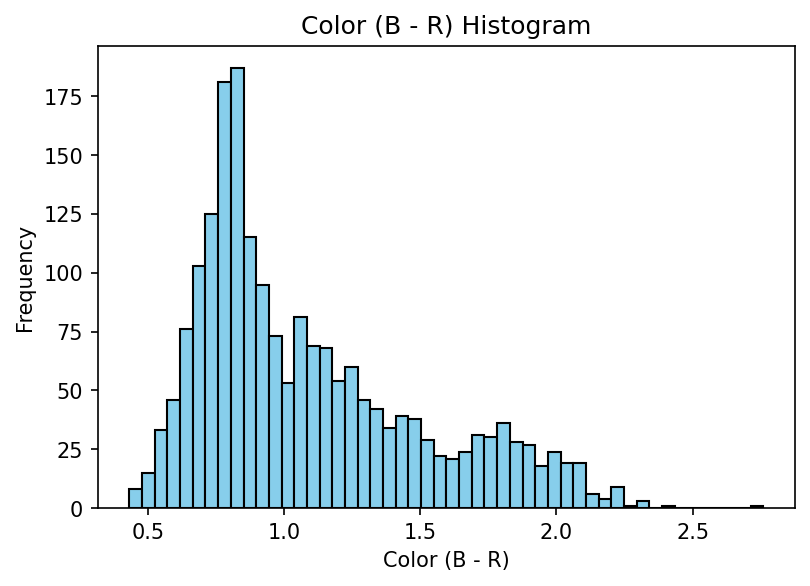

In [7]:
color = combined_df['Phot BP Mean Mag'] - combined_df['Phot RP Mean Mag']


# Create a high-resolution plot
plt.figure(figsize=(6, 4), dpi=150)  # Set the dpi to 300 for high resolution
plt.hist(color, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Color (B - R)')
plt.ylabel('Frequency')
plt.title('Color (B - R) Histogram')
plt.savefig('../figures/color_histogram.png', dpi=300)  # Save the plot as a PNG file
plt.show()

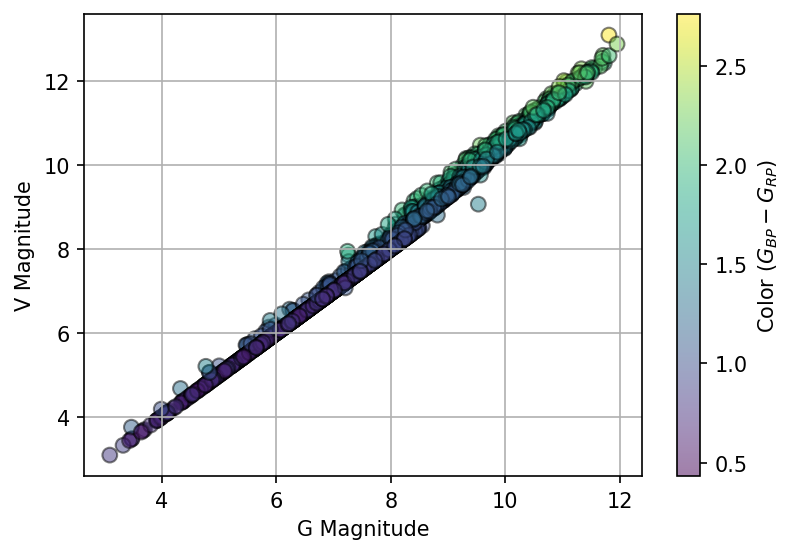

In [8]:

# Assuming 'color' is a column in combined_df or an array of the same length as the DataFrame
# For example, if 'color' is the difference between 'Phot BP Mean Mag' and 'Phot RP Mean Mag'
color = combined_df['Phot BP Mean Mag'] - combined_df['Phot RP Mean Mag']

# Calculate the conversion factor for colors between 1 and 4
conv = 0.20220 + 0.02489 * color

# Use np.where to apply the conversion conditionally
V_mag = np.where((color >= 1) & (color <= 4),
                 combined_df['Phot BP Mean Mag'] - conv,
                 combined_df['Phot G Mean Mag'])

# Create a high-resolution plot
plt.figure(figsize=(6, 4), dpi=150)  # Set the dpi to 300 for high resolution

# Plot the diagram using the color array for point colors
plt.scatter(combined_df['Phot G Mean Mag'], V_mag, c=color, cmap='viridis', edgecolor='k', s=50, alpha=0.5)
plt.xlabel('G Magnitude')
plt.ylabel('V Magnitude')
# plt.title('Color-Magnitude Diagram')
plt.colorbar(label='Color $(G_{BP} - G_{RP})$')
plt.grid()
plt.savefig('../figures/color_magnitude_diagram.png', dpi=300)
plt.show()


In [9]:
# List of columns to convert to numeric
columns_to_convert = ['T_eff [K]', 'Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]']

# Convert specified columns to numeric, coercing errors to NaN
for column in columns_to_convert:
    combined_df[column] = pd.to_numeric(combined_df[column], errors='coerce')

# Display the first few rows to verify the conversion
display(combined_df.head())

source_id        source_id_dr2        source_id_dr3          RA  \
0  5774205537990380160  5774205537990380160  5774205537990380160  266.926570   
1  6350283492745097728  6350283492745097728  6350283492745097728  355.984635   
2  1937497444157480320  1937497444157480320  1937497444157480320  351.670936   
3  3341047161115131904  3341047161115131904                  NaN   82.848866   
9  2835796794780262912  2835796794780262912  2835796794780262912  344.922611   

         DEC  Phot G Mean Mag  Phot BP Mean Mag  Phot RP Mean Mag     BP-RP  \
0 -82.217355         8.710826          9.220657          8.044305  1.176353   
1 -82.508908         7.540228          7.845232          7.064041  0.781191   
2  45.338617         7.245266          7.530724          6.697867  0.832856   
3  12.555511         8.182170          8.603820          7.641046  0.962774   
9  21.901615        10.190845         10.950277          9.333212  1.617065   

    Parallax    T_eff [K]  Mass [M_Sun]  Luminosity [L_Sun]  Radius [R_Sun]  \
0  32.132453  4791.793945      0.754562            0.266712        0.749355   
1  25.065155  5773.546387      0.982144            1.133842        1.064280   
2  28.522180  5560.500000      0.910111            1.200163        1.180414   
3  27.939951  5363.666504      0.878159            0.517248        0.849082   
9  26.308635  4123.754395      0.674252            0.134917        0.719647   

  Spectral Type  HD Number GJ Number  HIP Number Object Type  
0             K  HD 158866      None   HIP 87091     HighPM*  
1             G  HD 222669      None  HIP 117066     HighPM*  
2             F  HD 220821      None  HIP 115715     HighPM*  
3             G  HD  36308      None   HIP 25873     HighPM*  
9             K       None      None        None     HighPM*

In [10]:
# Insert the 'V_mag' column right after the 'DEC' column
combined_df.insert(combined_df.columns.get_loc('DEC') + 1, 'V_mag', V_mag)

if 'T_eff [K]' in combined_df.columns:

    # Calculate the HZ_limit
    hz_limits = combined_df.apply(lambda row: calculate_habitable_zone(row['T_eff [K]'], row['Luminosity [L_Sun]']), axis=1)
    # Find the index of the 'Radius [R_Sun]' column
    radius_index = combined_df.columns.get_loc('Radius [R_Sun]')
    # Insert the new column after 'Radius [R_Sun]'
    combined_df.insert(radius_index + 1, 'HZ_limit [AU]', hz_limits)
    # Sort the DataFrame by temperature (Teff)
    combined_df = combined_df.sort_values('T_eff [K]')    

# Export the combined DataFrame to an Excel file
combined_excel_file = 'combined_query.xlsx'
output_path = directory + combined_excel_file
combined_df.to_excel(output_path, index=False)

print(f"Combined results saved to {output_path}")
display(combined_df.head())

# Adjust the column widths
adjust_column_widths(output_path)

Combined results saved to ../results/combined_query.xlsx


source_id        source_id_dr2        source_id_dr3  \
816   2395297767716696704  2395297767716696704  2395297767716696704   
1622  1829571684890816384  1829571684890816384  1829571684890816384   
586   3113099227947062656  3113099227947062656  3113099227947062656   
2379  6594778590582157824  6594778590582157824  6594778590582157824   
902   5703698671959786880  5703698671959786880  5703698671959786880   

              RA        DEC      V_mag  Phot G Mean Mag  Phot BP Mean Mag  \
816   352.855379 -16.267225  13.087064        11.810668         13.357962   
1622  304.955668  22.943922  12.002273        11.022511         12.264630   
586   105.314731   0.877893  12.284532        11.329303         12.544342   
2379  334.961606 -38.543832  12.874390        11.952787         13.133586   
902   129.487342 -20.219873  12.180328        11.270885         12.440108   

      Phot RP Mean Mag     BP-RP  ...    T_eff [K]  Mass [M_Sun]  \
816          10.597902  2.760059  ...  3039.229736      0.551330   
1622          9.847702  2.416928  ...  3213.564941      0.570830   
586          10.229737  2.314605  ...  3248.140625      0.533085   
2379         10.843681  2.289905  ...  3279.611572      0.549933   
902          10.126722  2.313386  ...  3288.525146      0.592422   

      Luminosity [L_Sun]  Radius [R_Sun]  HZ_limit [AU]  Spectral Type  \
816             0.057685        0.614149       0.258216              M   
1622            0.062149        0.803743       0.267513              M   
586             0.046440        0.667171       0.231157              M   
2379            0.056906        0.575722       0.255790              M   
902             0.071747        0.625823       0.287184              M   

     HD Number GJ Number HIP Number Object Type  
816       None      None       None     HighPM*  
1622      None      None       None     HighPM*  
586       None      None       None     HighPM*  
2379      None      None       None     HighPM*  
902       None      None       None     HighPM*  

[5 rows x 21 columns]

In [11]:
from rv_prec import calculate_rv_precision

rv_precisions = []

for i in range(len(combined_df)):
    result, rv_precision = calculate_rv_precision(Temp=combined_df.iloc[i]['T_eff [K]'], Vmag=combined_df.iloc[i]['V_mag'])
    rv_precisions.append(rv_precision)

In [12]:
# Find the index of 'HZ_limit [AU]' column
hz_limit_index = combined_df.columns.get_loc('HZ_limit [AU]')

# Insert the rv_precisions to the right of 'HZ_limit [AU]'
combined_df.insert(hz_limit_index + 1, 'RV precision [m/s]', rv_precisions)

In [13]:
merged_df = combined_df.copy()

# Save the updated Excel file
output_path = directory + 'combined_query_with_RV_precision.xlsx'
merged_df.to_excel(output_path, index=False)

# Adjust the column widths
adjust_column_widths(output_path)

### Calculate the HZ mass detection limit

In [14]:
from scipy import optimize

# Constants
G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
M_earth = 5.97e24  # Earth mass in kg
M_sun = 1.989e30  # Solar mass in kg
AU = 1.496e11  # 1 AU in meters

def calculate_hz_detection_limit(K, stellar_mass, orbital_radius):
    """
    Calculate the minimum detectable planet mass in the Habitable Zone.
    
    :param K: RV precision in m/s
    :param stellar_mass: Mass of the star in solar masses
    :param orbital_radius: Orbital radius (HZ limit) in AU
    :return: Minimum detectable planet mass in Earth masses or np.nan if calculation fails
    """
    try:
        stellar_mass_kg = stellar_mass * M_sun
        orbital_radius_m = orbital_radius * AU
        
        if K <= 0 or stellar_mass_kg <= 0 or orbital_radius_m <= 0:
            return np.nan
        
        def equation(m_p):
            return K - (G**(1/2) * orbital_radius_m**(-1/2) * m_p * (stellar_mass_kg + m_p)**(-1/2))
        
        # Use numerical method to solve the equation
        planet_mass_kg = optimize.brentq(equation, 0, stellar_mass_kg)
        
        return planet_mass_kg / M_earth
    except:
        return np.nan

# Apply the calculation to each row
merged_df['HZ Detection Limit [Earth Mass]'] = merged_df.apply(
    lambda row: calculate_hz_detection_limit(
        row['RV precision [m/s]'],
        row['Mass [M_Sun]'],
        row['HZ_limit [AU]']
    ),
    axis=1
)

# Print some statistics about the new column
print(merged_df['HZ Detection Limit [Earth Mass]'].describe())

# Count and print the number of NaN values
nan_count = merged_df['HZ Detection Limit [Earth Mass]'].isna().sum()
print(f"Number of NaN values: {nan_count}")

# Reorder the columns to place the new column next to 'Mass'
cols = merged_df.columns.tolist()
mass_index = cols.index('RV precision [m/s]')
cols.insert(mass_index + 1, cols.pop(cols.index('HZ Detection Limit [Earth Mass]')))
merged_df = merged_df[cols]

# Save the updated DataFrame
output_path = directory + 'combined_query_with_mass_detection_limit.xlsx'
merged_df.to_excel(output_path, index=False)

# Adjust the column widths
adjust_column_widths(output_path)

print(f"Updated DataFrame saved to '{output_path}'.")


count    1994.000000
mean        4.814095
std         7.739638
min         0.246737
25%         2.036200
50%         2.603150
75%         3.176078
max        59.439005
Name: HZ Detection Limit [Earth Mass], dtype: float64
Number of NaN values: 0
Updated DataFrame saved to '../results/combined_query_with_mass_detection_limit.xlsx'.


### Statistics and plots

In [15]:
print(merged_df.columns.tolist())

['source_id', 'source_id_dr2', 'source_id_dr3', 'RA', 'DEC', 'V_mag', 'Phot G Mean Mag', 'Phot BP Mean Mag', 'Phot RP Mean Mag', 'BP-RP', 'Parallax', 'T_eff [K]', 'Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]', 'HZ_limit [AU]', 'RV precision [m/s]', 'HZ Detection Limit [Earth Mass]', 'Spectral Type', 'HD Number', 'GJ Number', 'HIP Number', 'Object Type']


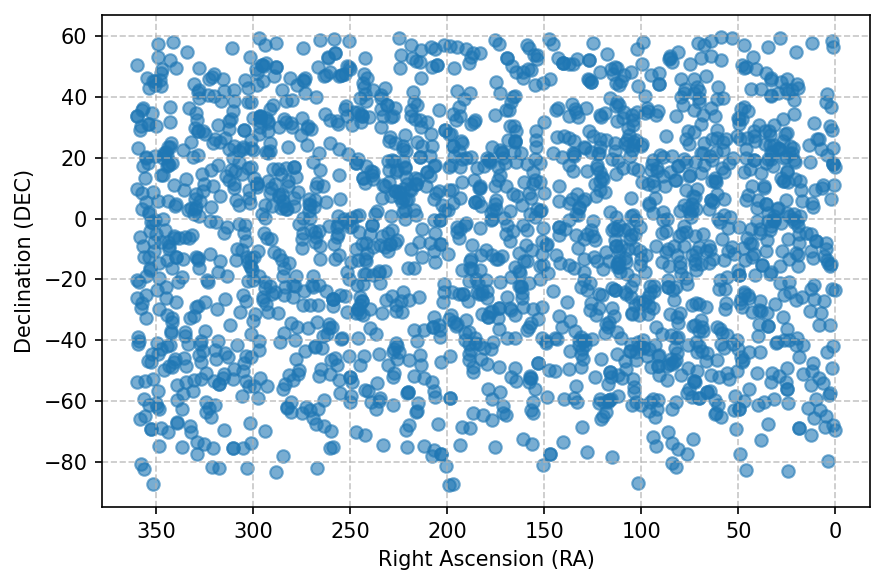

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4), dpi=150)
plt.scatter(merged_df['RA'], merged_df['DEC'], alpha=0.6)
plt.xlabel('Right Ascension (RA)')
plt.ylabel('Declination (DEC)')
plt.grid(True, linestyle='--', alpha=0.7)

# Invert the x-axis to match astronomical convention (RA increases to the left)
plt.gca().invert_xaxis()

plt.tight_layout()
plt.savefig('../figures/ra_dec.png', dpi=300)
plt.show()


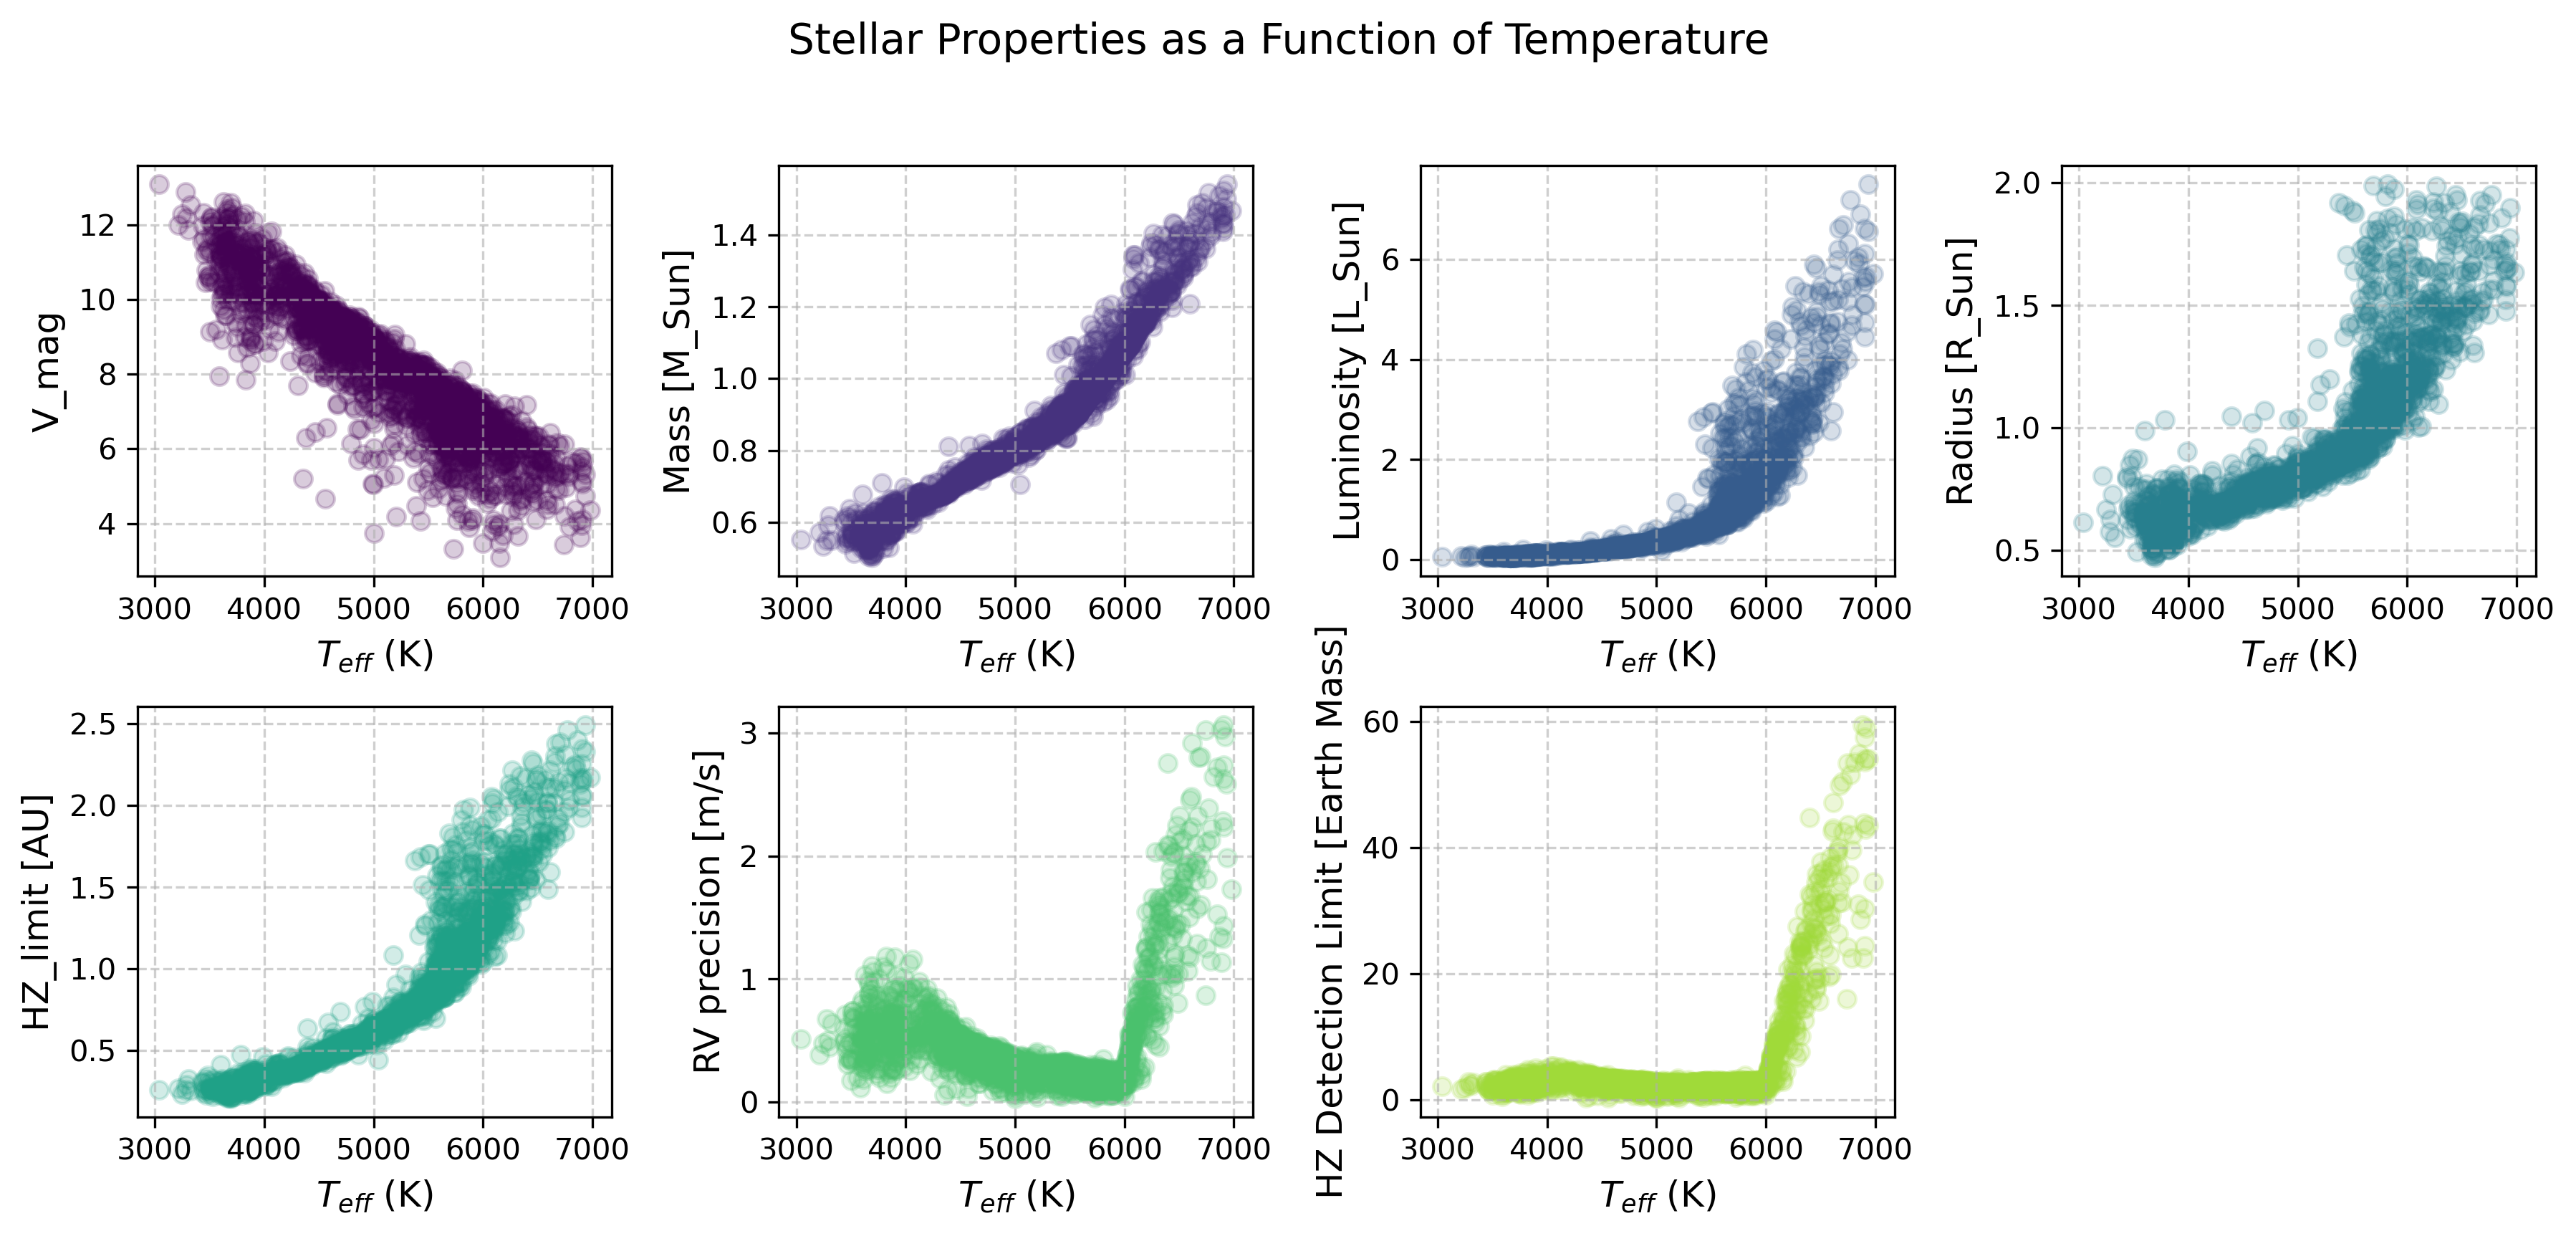

In [17]:
import matplotlib.pyplot as plt

# Create the plot
fig, axs = plt.subplots(2, 4, figsize=(12, 6), dpi=300)

# Flatten the axs array for easier iteration
axs = axs.flatten()

# List of columns to plot
columns = ['V_mag', 'Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]', 'HZ_limit [AU]', 
           'RV precision [m/s]', 'HZ Detection Limit [Earth Mass]']

# Define a color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(columns)+1))

# Plot each column
for i, col in enumerate(columns):
    axs[i].scatter(merged_df['T_eff [K]'], merged_df[col], alpha=0.2, color=colors[i])
    axs[i].set_xlabel('$T_{eff}$ (K)', fontsize=12)
    axs[i].set_ylabel(col, fontsize=12)
    axs[i].grid(True, linestyle='--', alpha=0.6)

# Remove the last unused subplot
fig.delaxes(axs[-1])

# Add a main title
fig.suptitle('Stellar Properties as a Function of Temperature', fontsize=14)

# Adjust the layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../figures/stellar_properties_vs_temperature.png')
plt.show()


In [18]:
merged_df['RV precision [m/s]']

816     0.511642
1622    0.384568
586     0.479786
2379    0.677797
902     0.502130
          ...   
59      2.236341
3135    2.967081
1594    2.584395
3318    1.984591
2023    1.730224
Name: RV precision [m/s], Length: 1994, dtype: float64

/var/folders/cg/kzyfvcpd4v52gb0tmxfhvrkm0000gp/T/ipykernel_4890/923546143.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


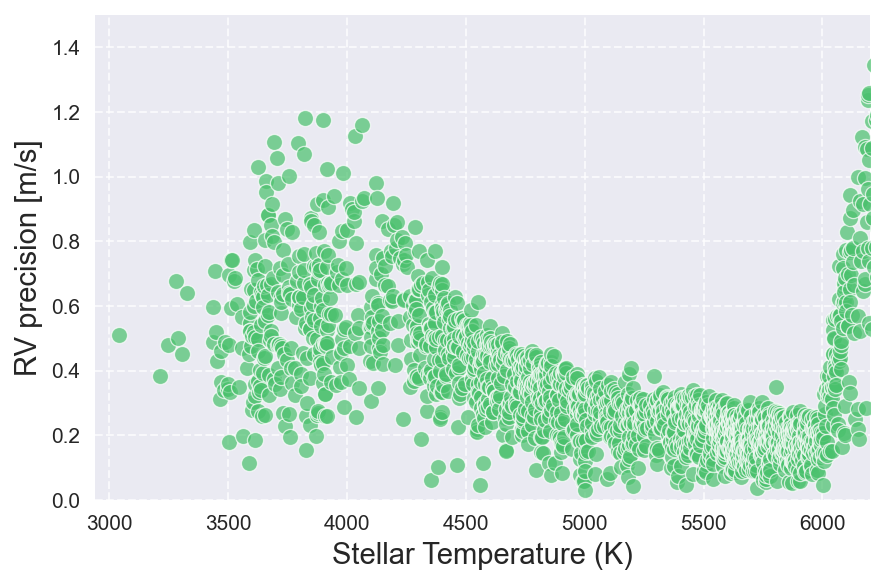

In [19]:
# Set the style for a more modern look
import seaborn as sns
plt.style.use('seaborn')
# sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(6, 4), dpi=150)
sns.scatterplot(x='T_eff [K]', y='RV precision [m/s]', data=merged_df, 
                color=colors[i-1], alpha=0.7, s=60)


# Customize the plot
plt.xlabel('Stellar Temperature (K)', fontsize=14)
plt.ylabel('RV precision [m/s]', fontsize=14)
plt.xlim(min(merged_df['T_eff [K]']) - 100, 6000 + 200)
plt.ylim(0, 1.5)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Customize tick labels
plt.tick_params(axis='both', which='major')


# Adjust layout and display the plot
plt.tight_layout()
plt.show()

/var/folders/cg/kzyfvcpd4v52gb0tmxfhvrkm0000gp/T/ipykernel_4890/3956436646.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


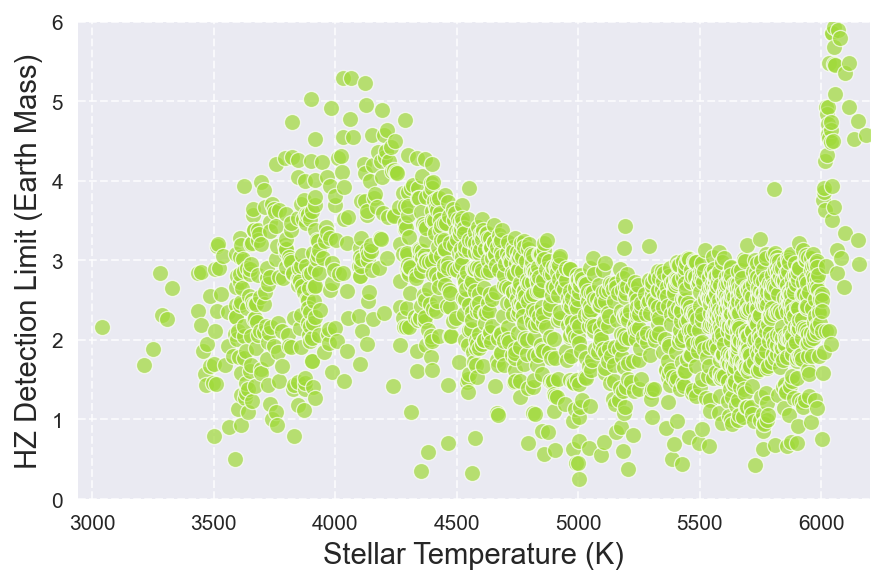

In [20]:
# Set the style for a more modern look
import seaborn as sns
plt.style.use('seaborn')
# sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(6, 4), dpi=150)
sns.scatterplot(x='T_eff [K]', y='HZ Detection Limit [Earth Mass]', data=merged_df, 
                color=colors[i], alpha=0.7, s=60)


# Customize the plot
plt.xlabel('Stellar Temperature (K)', fontsize=14)
plt.ylabel('HZ Detection Limit (Earth Mass)', fontsize=14)
plt.xlim(min(merged_df['T_eff [K]']) - 100, 6000 + 200)
plt.ylim(0, 6)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Customize tick labels
plt.tick_params(axis='both', which='major')


# Adjust layout and display the plot
plt.tight_layout()
plt.show()

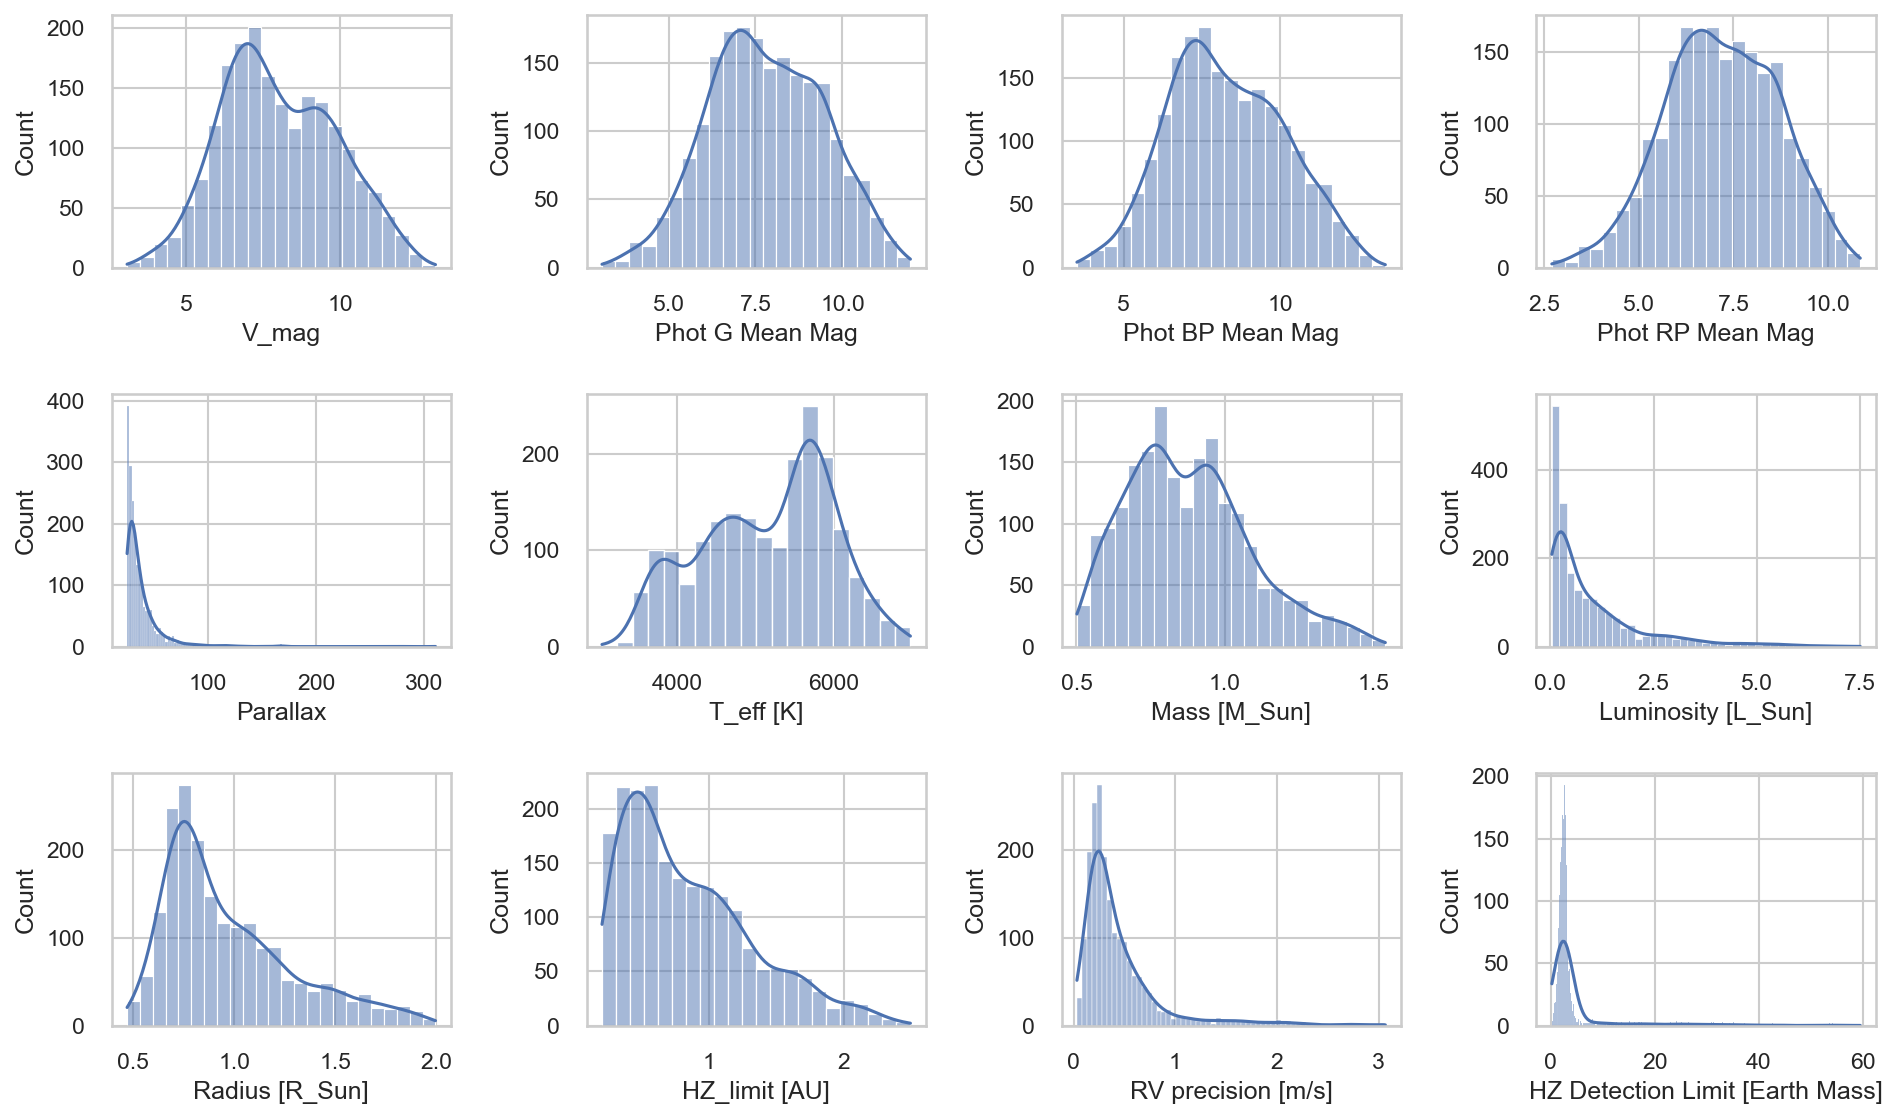

In [21]:
sns.set_theme(style="whitegrid")

# List of columns to plot
columns_to_plot = [
    'V_mag', 'Phot G Mean Mag', 'Phot BP Mean Mag', 'Phot RP Mean Mag',
    'Parallax', 'T_eff [K]', 'Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]', 'HZ_limit [AU]', 
           'RV precision [m/s]', 'HZ Detection Limit [Earth Mass]'
]

# Set up the plot
fig, axes = plt.subplots(3, 4, figsize=(12, 8), dpi=150)
# fig.suptitle('Histograms of Stellar Properties', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create histograms
for i, column in enumerate(columns_to_plot):
    sns.histplot(data=merged_df, x=column, kde=True, ax=axes[i])
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

# Adjust layout and display
plt.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.5, wspace=0.4, left=0.01, right=0.99)
plt.savefig('../figures/star_properties_histograms.png')
plt.show()


In [22]:
merged_df

source_id        source_id_dr2        source_id_dr3  \
816   2395297767716696704  2395297767716696704  2395297767716696704   
1622  1829571684890816384  1829571684890816384  1829571684890816384   
586   3113099227947062656  3113099227947062656  3113099227947062656   
2379  6594778590582157824  6594778590582157824  6594778590582157824   
902   5703698671959786880  5703698671959786880  5703698671959786880   
...                   ...                  ...                  ...   
59     854734436486835840   854734436486835840   854734436486835840   
3135   974158613492226816                  NaN   974158613492226816   
1594  3496266901235127808  3496266901235127808  3496266901235127808   
3318  4408631032807405696                  NaN  4408631032807405696   
2023  4815660547961306112  4815660547961306112  4815660547961306112   

              RA        DEC      V_mag  Phot G Mean Mag  Phot BP Mean Mag  \
816   352.855379 -16.267225  13.087064        11.810668         13.357962   
1622  304.955668  22.943922  12.002273        11.022511         12.264630   
586   105.314731   0.877893  12.284532        11.329303         12.544342   
2379  334.961606 -38.543832  12.874390        11.952787         13.133586   
902   129.487342 -20.219873  12.180328        11.270885         12.440108   
...          ...        ...        ...              ...               ...   
59    158.790934  57.082800   5.062257         5.062257          5.244514   
3135  110.322611  45.228222   5.655417         5.655417          5.827671   
1594  189.426563 -27.139312   5.316832         5.316832          5.489301   
3318  245.517414   1.029268   4.739257         4.739257          4.902911   
2023   70.139634 -41.864088   4.350951         4.350951          4.530210   

      Phot RP Mean Mag     BP-RP  ...  Luminosity [L_Sun]  Radius [R_Sun]  \
816          10.597902  2.760059  ...            0.057685        0.614149   
1622          9.847702  2.416928  ...            0.062149        0.803743   
586          10.229737  2.314605  ...            0.046440        0.667171   
2379         10.843681  2.289905  ...            0.056906        0.575722   
902          10.126722  2.313386  ...            0.071747        0.625823   
...                ...       ...  ...                 ...             ...   
59            4.758277  0.486238  ...            5.095541        1.576123   
3135          5.353816  0.473855  ...            5.657654        1.656137   
1594          5.018359  0.470942  ...            6.562787        1.775113   
3318          4.429553  0.473358  ...            7.509193        1.897733   
2023          4.057098  0.473111  ...            5.711953        1.635618   

      HZ_limit [AU]  RV precision [m/s]  HZ Detection Limit [Earth Mass]  \
816        0.258216            0.511642                         2.159098   
1622       0.267513            0.384568                         1.680763   
586        0.231157            0.479786                         1.883680   
2379       0.255790            0.677797                         2.843190   
902        0.287184            0.502130                         2.316434   
...             ...                 ...                              ...   
59         2.055717            2.236341                        42.913288   
3135       2.165100            2.967081                        58.963627   
1594       2.329769            2.584395                        54.049789   
3318       2.491859            1.984591                        43.496515   
2023       2.168664            1.730224                        34.517715   

      Spectral Type              HD Number  \
816               M                   None   
1622              M                   None   
586               M                   None   
2379              M                   None   
902               M                   None   
...             ...                    ...   
59                F              HD  91480   
3135              F             

In [23]:
if 0: 
    # Create the 'source_id' column
    merged_df['source_id'] = np.where(merged_df['dr2_source_id'].notna(), merged_df['dr2_source_id'], merged_df['dr3_source_id'])

    # Move the 'source_id' column to the first position
    columns = ['source_id'] + [col for col in merged_df if col != 'source_id']
    merged_df = merged_df[columns]

    # Display the first few rows to verify the changes
    display(merged_df.head())

In [24]:
# read SEI_target_selection.xlsx file into a pandas DataFrame
import pandas as pd
df_Melissa = pd.read_excel('../data/SEI_target_selection.xlsx')
df_Melissa['Gaia name'] = df_Melissa['Gaia name'].astype(str)

In [25]:
merged_result = df_Melissa.merge(merged_df, left_on="Gaia name", right_on="source_id", how="inner", suffixes=('_M', '_J'))
filename = directory + 'merged_result_MJ.xlsx'
merged_result.to_excel(filename, index=False)
adjust_column_widths(filename)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


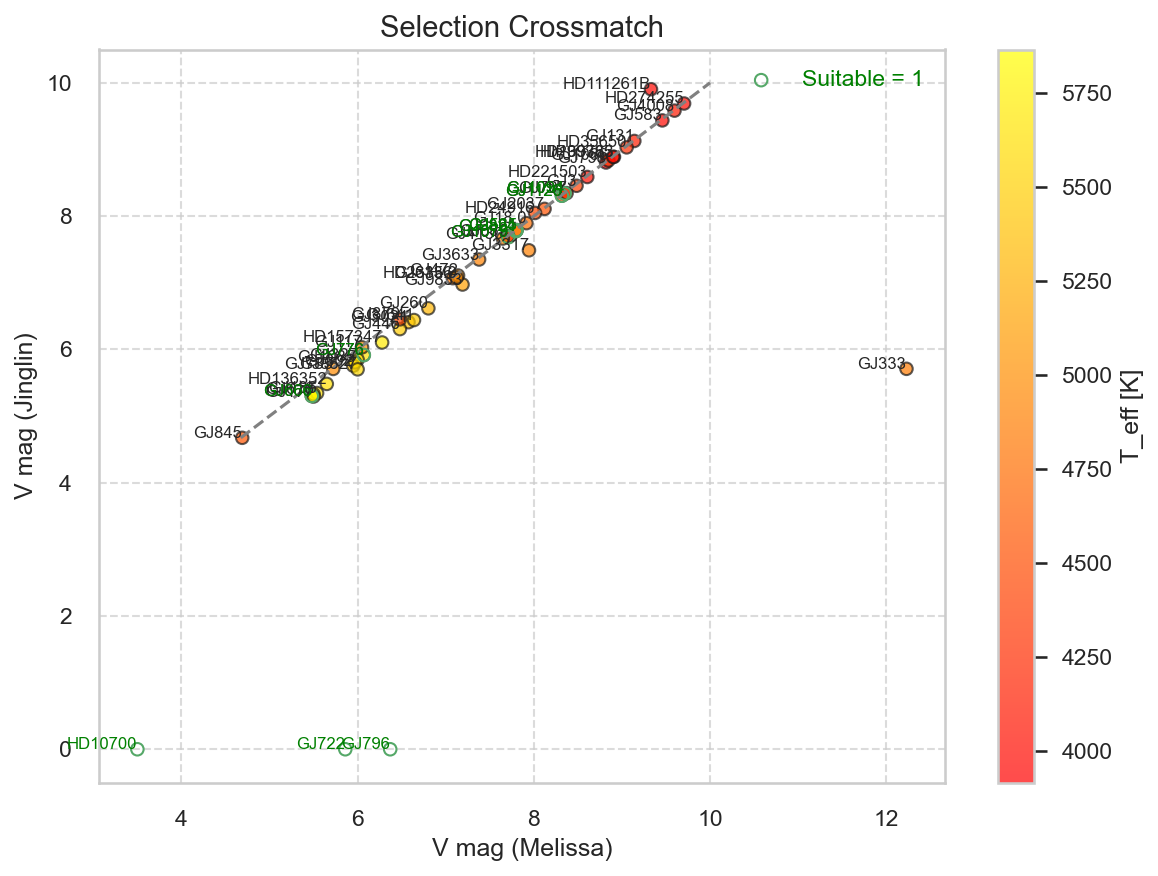

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot with color mapping
plt.figure(figsize=(8, 6), dpi=150)
scatter = plt.scatter(
    merged_result['Vmag'], 
    merged_result['V_mag'], 
    c=merged_result['T_eff [K]'], 
    cmap='autumn', 
    edgecolor='k', 
    alpha=0.7
)

# Add labels to each point
for i, name in enumerate(merged_result['other name']):
    plt.text(merged_result['Vmag'][i], merged_result['V_mag'][i], name, fontsize=8, ha='right')

# Add titles and labels
plt.title('Selection Crossmatch', fontsize=14)
plt.xlabel('V mag (Melissa)', fontsize=12)
plt.ylabel('V mag (Jinglin)', fontsize=12)

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('T_eff [K]', fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Overplot the suitable points from df_Melissa
suitable_indices = df_Melissa['suitable'] == 1
name_suitable = df_Melissa.loc[suitable_indices, 'other name']

x_suitable = []
y_suitable = []

for name in name_suitable:
    x_value = df_Melissa.loc[df_Melissa['other name'] == name, 'Vmag'].values[0]
    if name in merged_result['other name'].values:        
        y_value = merged_result.loc[merged_result['other name'] == name, 'V_mag'].values[0]
    else:
        y_value = 0
    x_suitable.append(x_value)
    y_suitable.append(y_value)

    plt.text(x_value, y_value, name, fontsize=8, ha='right', color='green')

# Plot the suitable points
plt.scatter(x_suitable, y_suitable, edgecolor='g', facecolors='none', label='Suitable = 1')

# Plot the x = y line
min_value = min(min(merged_result['Vmag']), min(merged_result['V_mag']))
max_value = 10
plt.plot([min_value, max_value], [min_value, max_value], color='gray', linestyle='--', )

# Add legend
legend = plt.legend()
for text in legend.get_texts():
    text.set_color('green')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# 6721432232656218752	6721432232656219136	273,0899282	-43,44664533	7,843331814	8,609505653	7,023746014	1,58575964	75,74537047	4235.4004	0.66545904	0.13317624	0.6776436	K				
# 	               6721432232656218752	273,0899538	-43,44670336	7,846924782	8,58617115	7,012911797	1,573259354	75,71222519	4235.4004	0.66545904	0.13317624	0.6776436	K	HD 166348	GJ 707	HIP 89211	HighPM*


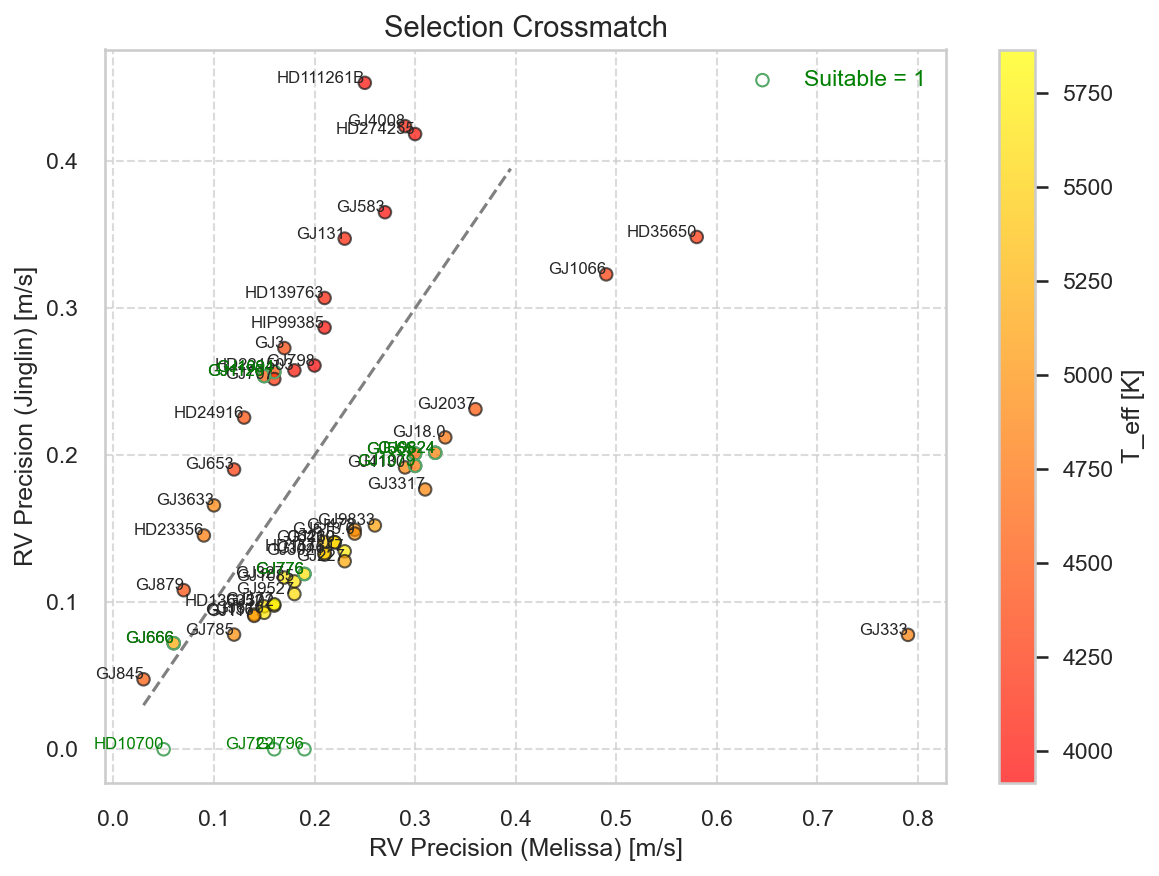

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot with color mapping
plt.figure(figsize=(8, 6), dpi=150)
scatter = plt.scatter(
    merged_result['Reiners RV precision'], 
    merged_result['RV precision [m/s]'], 
    c=merged_result['T_eff [K]'], 
    cmap='autumn', 
    edgecolor='k', 
    alpha=0.7
)

# Add labels to each point
for i, name in enumerate(merged_result['other name']):
    plt.text(merged_result['Reiners RV precision'][i], merged_result['RV precision [m/s]'][i], name, fontsize=8, ha='right')

# Add titles and labels
plt.title('Selection Crossmatch', fontsize=14)
plt.xlabel('RV Precision (Melissa) [m/s]', fontsize=12)
plt.ylabel('RV Precision (Jinglin) [m/s]', fontsize=12)

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('T_eff [K]', fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Overplot the suitable points from df_Melissa
suitable_indices = df_Melissa['suitable'] == 1
name_suitable = df_Melissa.loc[suitable_indices, 'other name']

x_suitable = []
y_suitable = []

for name in name_suitable:
    x_value = df_Melissa.loc[df_Melissa['other name'] == name, 'Reiners RV precision'].values[0]
    if name in merged_result['other name'].values:        
        y_value = merged_result.loc[merged_result['other name'] == name, 'RV precision [m/s]'].values[0]
    else:
        y_value = 0
    x_suitable.append(x_value)
    y_suitable.append(y_value)

    # name = df_Melissa.loc[df_Melissa['Reiners RV precision'] == x, 'other name'].values[0]
    plt.text(x_value, y_value, name, fontsize=8, ha='right', color='green')

# Plot the suitable points
plt.scatter(x_suitable, y_suitable, edgecolor='g', facecolors='none', label='Suitable = 1')

# Plot the x = y line
min_value = min(min(merged_result['Reiners RV precision']), min(merged_result['RV precision [m/s]']))
max_value = max(max(merged_result['Reiners RV precision'])*0.5, max(merged_result['RV precision [m/s]'])*0.5)
plt.plot([min_value, max_value], [min_value, max_value], color='gray', linestyle='--', )

# Add legend
legend = plt.legend()
for text in legend.get_texts():
    text.set_color('green')

# Show the plot
plt.tight_layout()
plt.savefig('../figures/RV_precision_comparison.png')
plt.show()


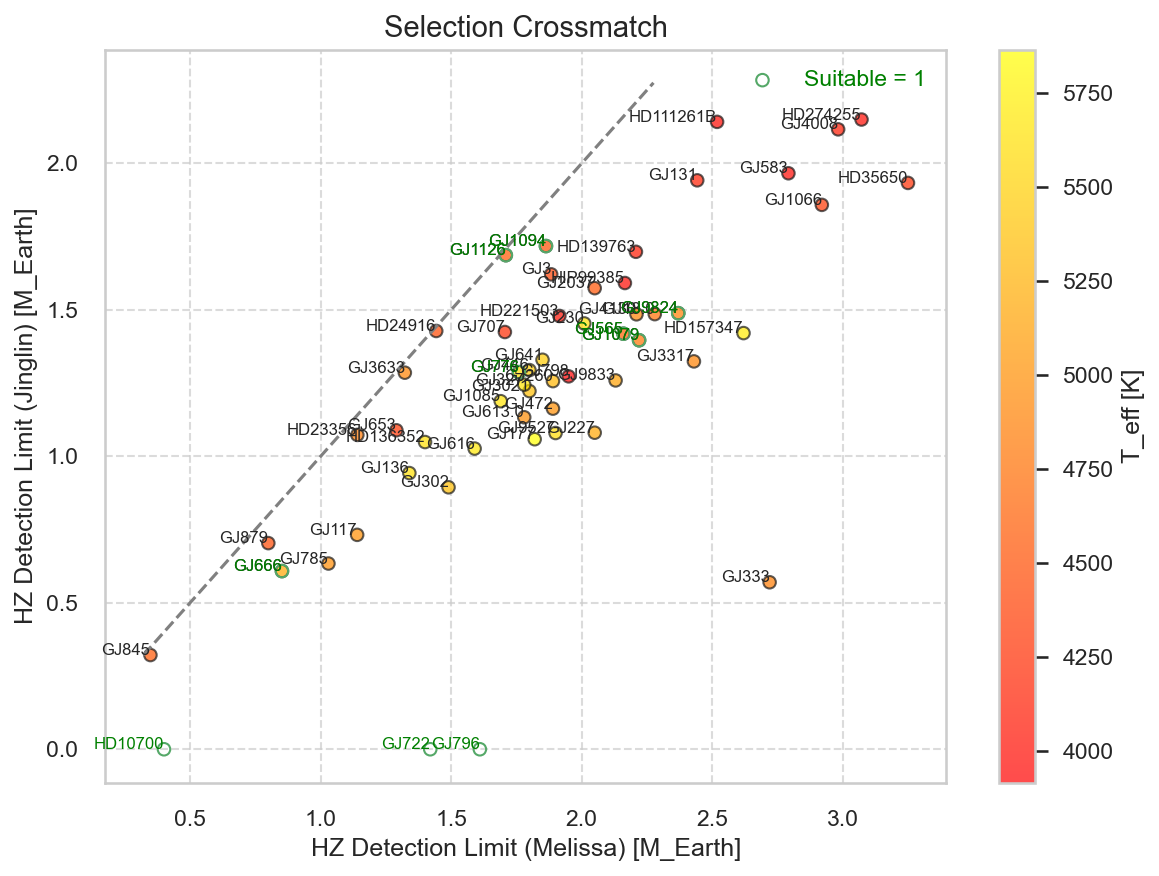

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Create a scatter plot with color mapping
plt.figure(figsize=(8, 6), dpi=150)
scatter = plt.scatter(
    merged_result['Reiners HZ Me limit'], 
    merged_result['HZ Detection Limit [Earth Mass]'], 
    c=merged_result['T_eff [K]'], 
    cmap='autumn', 
    edgecolor='k', 
    alpha=0.7
)

# Add labels to each point
for i, name in enumerate(merged_result['other name']):
    plt.text(merged_result['Reiners HZ Me limit'][i], merged_result['HZ Detection Limit [Earth Mass]'][i], name, fontsize=8, ha='right')

# Add titles and labels
plt.title('Selection Crossmatch', fontsize=14)
plt.xlabel('HZ Detection Limit (Melissa) [M_Earth]', fontsize=12)
plt.ylabel('HZ Detection Limit (Jinglin) [M_Earth]', fontsize=12)

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('T_eff [K]', fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Overplot the suitable points from df_Melissa
suitable_indices = df_Melissa['suitable'] == 1
name_suitable = df_Melissa.loc[suitable_indices, 'other name']

x_suitable = []
y_suitable = []

for name in name_suitable:
    x_value = df_Melissa.loc[df_Melissa['other name'] == name, 'Reiners HZ Me limit'].values[0]
    if name in merged_result['other name'].values:        
        y_value = merged_result.loc[merged_result['other name'] == name, 'HZ Detection Limit [Earth Mass]'].values[0]
    else:
        y_value = 0
    x_suitable.append(x_value)
    y_suitable.append(y_value)

    # Add red labels for suitable points
    plt.text(x_value, y_value, name, fontsize=8, ha='right', color='green')

# Plot the suitable points
plt.scatter(x_suitable, y_suitable, edgecolor='g', facecolors='none', label='Suitable = 1')

# Plot the x = y line
min_value = min(min(merged_result['Reiners HZ Me limit']), min(merged_result['HZ Detection Limit [Earth Mass]']))
max_value = max(max(merged_result['Reiners HZ Me limit'])*0.7, max(merged_result['HZ Detection Limit [Earth Mass]'])*0.7)
plt.plot([min_value, max_value], [min_value, max_value], color='gray', linestyle='--', )

# Add legend
legend = plt.legend()
for text in legend.get_texts():
    text.set_color('green')

# Show the plot
plt.tight_layout()
plt.savefig('../figures/HZ_detection_limit_comparison.png')
plt.show()



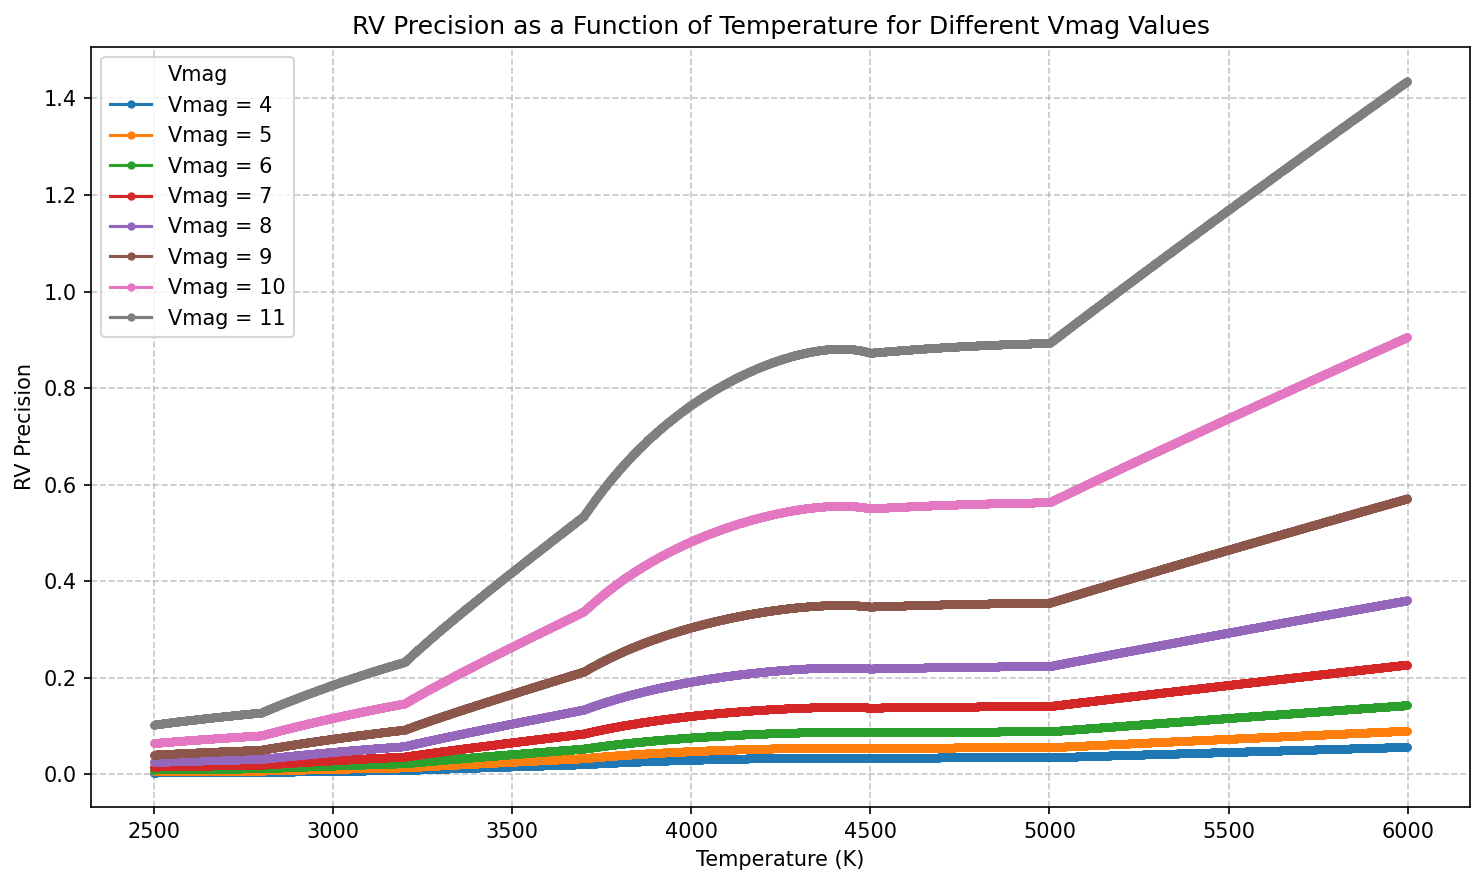

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Define temperature and Vmag ranges
temperatures = np.arange(2500, 6000, 1)
vmags = np.arange(4, 12, 1)

# Store RV precision results
rv_precision_results = {vmag: [] for vmag in vmags}

# Calculate RV precision for each combination of temperature and Vmag
for temperature in temperatures:
    for vmag in vmags:
        result, rv_precision = calculate_rv_precision(Temp=temperature, Vmag=vmag)
        rv_precision_results[vmag].append(rv_precision)

# Plotting
plt.figure(figsize=(10, 6), dpi=150)
for vmag, rv_precisions in rv_precision_results.items():
    plt.plot(temperatures, rv_precisions, label=f'Vmag = {vmag}', marker='.')

# Add titles and labels
plt.title('RV Precision as a Function of Temperature for Different Vmag Values')
plt.xlabel('Temperature (K)')
plt.ylabel('RV Precision')
plt.legend(title='Vmag')
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [231]:
from astroquery.vizier import Vizier
import pandas as pd

# Initialize Vizier with a row limit, you can adjust this as needed
Vizier.ROW_LIMIT = 100  # Set to -1 for no limit

# Define the catalog you want to query
catalog = "V/137D"  # This is an example catalog, you might need to adjust based on your needs

# Define the columns you are interested in
columns = ['Teff', 'Mass', 'Radius', 'Vmag']

# Perform the query
result = Vizier(columns=columns).query_constraints(catalog=catalog)

# Check if any results were returned
if result:
    # Convert the result to a pandas DataFrame
    df = result[0].to_pandas()
    
    # Display the first few rows of the DataFrame
    print(df.head())
else:
    print("No data found for the specified query.")

   Vmag
0  9.10
1  9.27
2  6.61
3  8.06
4  8.55


In [237]:
from astroquery.vizier import Vizier
import pandas as pd

# Initialize Vizier with a row limit
Vizier.ROW_LIMIT = 1  # Since we're looking for a specific star

# Example catalog: Hipparcos catalog
catalog = "I/239/hip_main"  # Hipparcos Main Catalogue

# Define the object name
star_name = "HD 10700"

# Perform the query
result = Vizier.query_object(star_name, catalog=catalog)

# Check if any results were returned
if result:
    # Convert the result to a pandas DataFrame
    df = result[0].to_pandas()
    
    # Print the available columns to see what data we have
    print("Available columns:", df.columns)
    
    # Display the first few rows of the DataFrame
    display(df.head())
else:
    print("No data found for the specified query.")


Available columns: Index(['HIP', 'RAhms', 'DEdms', 'Vmag', 'RAICRS', 'DEICRS', 'Plx', 'pmRA',
       'pmDE', 'e_Plx', 'B-V', 'Notes', '_RA.icrs', '_DE.icrs'],
      dtype='object')


HIP        RAhms        DEdms  Vmag     RAICRS     DEICRS         Plx  \
0  8102  01 44 05.13  -15 56 22.4  3.49  26.021364 -15.939556  274.170013   

      pmRA    pmDE  e_Plx    B-V Notes   _RA.icrs  _DE.icrs  
0 -1721.82  854.07    0.8  0.727        26.017012 -15.93748